# 02 - Data from the Web

In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need! You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this brief tutorial to understand quickly how to use it.

# Imports

In [1]:
# Import libraries
import string
import re
import pickle
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

%matplotlib inline

# Constans definition

In [2]:
QS_RANKING_URL = 'https://www.topuniversities.com/university-rankings/world-university-rankings/2018'
QS_RANKING_JSON = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508104120137'

TIMES_RANKING_URL = 'http://timeshighereducation.com/world-university-rankings/2018/world-ranking'
TIMES_RANKING_JSON = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

In [3]:
SEARCH_REFERENCE_API = 'https://en.wikipedia.org/w/api.php?action=query&titles={0}&prop=revisions&rvprop=content&format=json&indexpageids'

In [4]:
try:
    COUNTRY_REGION_METADATA = pd.read_pickle('serial/country_region_metadata.p')
except (OSError, IOError) as e:
    COUNTRY_REGION_METADATA = pd.DataFrame(columns=['Region'])
    COUNTRY_REGION_METADATA.to_pickle('serial/country_region_metadata.p')

In [5]:
COUNTRY_REGION_METADATA

,Region
United States,North America
United Kingdom,Europe
Switzerland,Europe
Singapore,Asia
Australia,Oceania
China,Asia
Hong Kong,Asia
Japan,Asia
Canada,North America
South Korea,Asia


# General use functions definition

In [6]:
def build_html_parser(url):
    '''
    Function to build a parser object of type BeautifulSoup
    
    url      the webpage url to which send a get request to
    
    return   a parser of the given webpage
    '''
    
    r = requests.get(url)
    page_body = r.text
    
    soup = BeautifulSoup(page_body, 'html.parser')
    
    return soup

In [7]:
def clean_str_number(str_n):
    
    return str_n.strip('\n').strip('%').replace(',', '')

In [8]:
def search_standard_name(str_name):
    
    str_name = str_name.split("-")[0] # Manage name with - (short)
    str_name = str_name.split("–")[0] # Manage name with – (long)
    str_name = re.sub('\(.*?\)','', str_name) # no brackets
    str_name = str_name.strip().replace('&', '%26')
    
    #r = requests.get(SEARCH_REFERENCE_API.format(str_name.strip().replace(' ', '%20')))
    r = requests.get(SEARCH_REFERENCE_API.format(str_name.strip().replace(' ', '_')))
    data = r.json()
    
    page_id = data['query']['pageids'][0]
    
    if (page_id == '-1'):
        print('Not found :( -> {}'.format(str_name))
        
        # Manually set a standard name for the only unmatchable university. 
        # We have a total of 9 unknown sources during the WikiData requests, but only one university appears twice
        # and it need to receive a standard name to be merged later on. The other onces could keep their name
        if (str_name == "Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento"):
            found_name = "Scuola Superiore Sant’Anna"
        else:
            found_name = str_name
    else:
        found_name = data['query']['pages'][page_id]['title']
        
    return(found_name)

In [9]:
def update_country_region_metadata(country, region):
    
    global COUNTRY_REGION_METADATA
    
    if (country in COUNTRY_REGION_METADATA.index):
        return
    
    new_row = pd.Series(region, index=['Region'])
    new_row.name = country
    
    COUNTRY_REGION_METADATA = COUNTRY_REGION_METADATA.append(new_row)

### Task 1
Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018)

In [10]:
# TODO: Handled the returning value for data not found. 
# Atm I return a -1, but this fucks up the plotting and computation for the ratios

def parse_detail_page(url_detail):
    '''
    Function that parses the missing informations from the detail page of the university from the QS website
    
    Return   a dictionary with all the data found as integers values
    '''
    
    # Build a parser for the detail page
    soup = build_html_parser(url_detail)
    
    # Obtain and clean up the total faculty member value
    try:
        faculty_member_total = soup.find('div', class_='total faculty').find('div', class_='number').text
        faculty_member_total = clean_str_number(faculty_member_total)
    except:
        faculty_member_total = -1
    
    
    # Obtain and clean up the international faculty member value
    try:
        faculty_member_inter = soup.find('div', class_='inter faculty').find('div', class_='number').text.strip('\n')
        faculty_member_inter = clean_str_number(faculty_member_inter)
    except:
        faculty_member_inter = -1
    
    # Obtain and clean up the total students value
    try:
        student_total = soup.find('div', class_='total student').find('div', class_='number').text.strip('\n')
        student_total = clean_str_number(student_total)
    except:
        student_total = -1
    
    # Obtain and clean up the international students value
    try:
        student_inter = soup.find('div', class_='total inter').find('div', class_='number').text.strip('\n')
        student_inter = clean_str_number(student_inter)
    except:
        student_inter = -1
    
    # Build a dictionary for the parsed informations
    detail_info = {'Total faculty member' : int(faculty_member_total), 
                   'International faculty member' : int(faculty_member_inter), 
                   'Total student' : int(student_total), 
                   'International student' : int(student_inter)
                  }
    
    return detail_info

After some work on the Postman Inspector, we found out that the GET Request made to the QS website ended up with multiple attached files to go with the response. One of those files was a JSON with all the infos from the ranking.

In [11]:
req = requests.get(QS_RANKING_JSON)
data_from_url = req.json()

Such data is stored as a list of dictionaries, as visible in the example below:

In [12]:
print('First cell:')
print(data_from_url['data'][0], end='\n\n')

print('Second cell:')
print(data_from_url['data'][1], end='\n\n')

print('...')

First cell:
{'nid': '294850', 'url': '/universities/massachusetts-institute-technology-mit', 'title': 'Massachusetts Institute of Technology (MIT)', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">', 'core_id': '410', 'score': '100', 'rank_display': '1', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '6', 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>'}

Second cell:
{'nid': '297282', 'url': '/universities/stanford-university', 'title': 'Stanford University', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/stanford-university_573_small_0.jpg" alt="Stanford University Logo">', 'core_id': '573', 'score': '98.7', 'rank_display': '2', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '5', 'guide': '<a h

In [13]:
def scrape_qs_ranking():
    '''
    Obtain the ranking from QS in a dataframe
    '''
    
    r = requests.get(QS_RANKING_JSON)
    data = r.json()
    
    university_list = []

    # Iterate throu the first 200 elments of the list
    for d in data['data'][:200]:
    
        # Store the parsed information into a dictionary
        info = {'Rank': d['rank_display'], 
                'University name': search_standard_name(d['title']), 
                'Country': d['country'],
                'Region' : d['region']
               }
    
        update_country_region_metadata(d['country'], d['region'])
    
        # Extend the dictionary with the informations in the detail page
        url_detail = 'https://www.topuniversities.com' +  d['url']
        info.update( parse_detail_page( url_detail))
    
        university_list.append(info)
    
    # After scraping data from QS ranking the metadata dataframe needs to be stored updated
    COUNTRY_REGION_METADATA.to_pickle('serial/country_region_metadata.p')
    
    qs_ranking_df = pd.DataFrame.from_dict(university_list)
    return qs_ranking_df

In [14]:
try:
    qs_ranking_df = pd.read_pickle('serial/qs_save.p')
except (OSError, IOError) as e:
    qs_ranking_df = scrape_qs_ranking()
    qs_ranking_df.to_pickle('serial/qs_save.p')
    
qs_ranking_df.head()

,Country,International faculty member,International student,Rank,Region,Total faculty member,Total student,University name
0,United States,1679,3717,1,North America,2982,11067,Massachusetts Institute of Technology
1,United States,2042,3611,2,North America,4285,15878,Stanford University
2,United States,1311,5266,3,North America,4350,22429,Harvard University
3,United States,350,647,4,North America,953,2255,California Institute of Technology
4,United Kingdom,2278,6699,5,Europe,5490,18770,University of Cambridge


In [15]:
qs_ranking_df.set_index(['University name'], inplace=True)

#### Which are the best universities in term of ratio between faculty members and students?

In [38]:
qs_ranking_df['Faculty/students ratio'] = qs_ranking_df['Total faculty member'] / qs_ranking_df['Total student']

faculty_students_rank_df = qs_ranking_df[['Country', 'Region', 'Total faculty member', 'Total student', 'Faculty/students ratio']]
faculty_students_rank_df = faculty_students_rank_df.sort_values('Faculty/students ratio', ascending=False)

faculty_students_rank_df.head()

,Country,Region,Total faculty member,Total student,Faculty/students ratio
University name,,,,,
New York University,United States,North America,-1,-1,1.000000
California Institute of Technology,United States,North America,953,2255,0.422616
Yale University,United States,North America,4940,12402,0.398323
University of Oxford,United Kingdom,Europe,6750,19720,0.342292
University of Cambridge,United Kingdom,Europe,5490,18770,0.292488


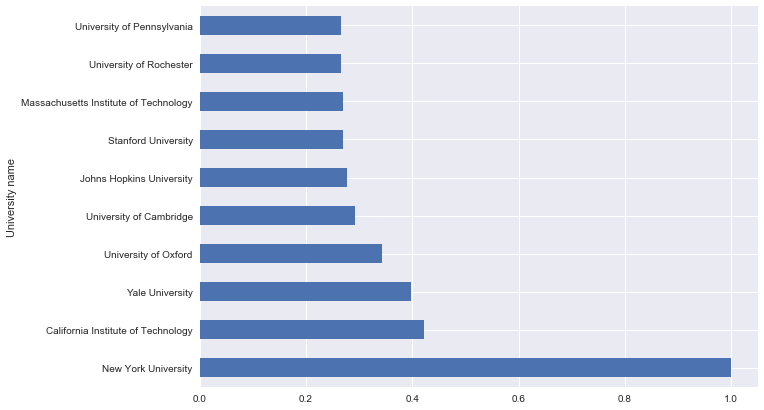

In [42]:
faculty_students_rank_df[:10]['Faculty/students ratio'].plot(kind='barh', figsize=(10,7))

#### Which are the best universities in term of ratio of international students?

In [43]:
qs_ranking_df['Intern/student ratio'] = qs_ranking_df['International student'] / qs_ranking_df['Total student']

international_students_rank_df = qs_ranking_df[['Country', 'Region', 'International student', 'Total student', 'Intern/student ratio']]
international_students_rank_df = international_students_rank_df.sort_values('Intern/student ratio', ascending=False)

international_students_rank_df.head()

,Country,Region,International student,Total student,Intern/student ratio
University name,,,,,
New York University,United States,North America,-1,-1,1.000000
London School of Economics and Political Science,United Kingdom,Europe,6748,9760,0.691393
Ecole Polytechnique Fédérale de Lausanne,Switzerland,Europe,5896,10343,0.570047
Imperial College London,United Kingdom,Europe,8746,16090,0.543567
Maastricht University,Netherlands,Europe,8234,16385,0.502533


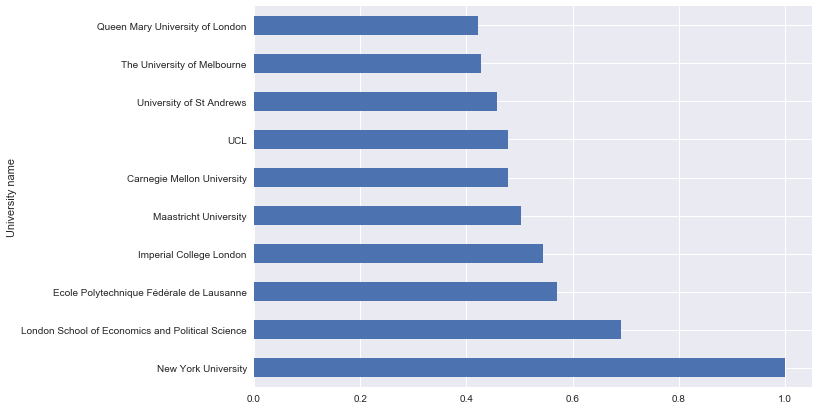

In [44]:
international_students_rank_df[:10]['Intern/student ratio'].plot(kind='barh', figsize=(10,7))

Plot of the dataframe for the ratios computed

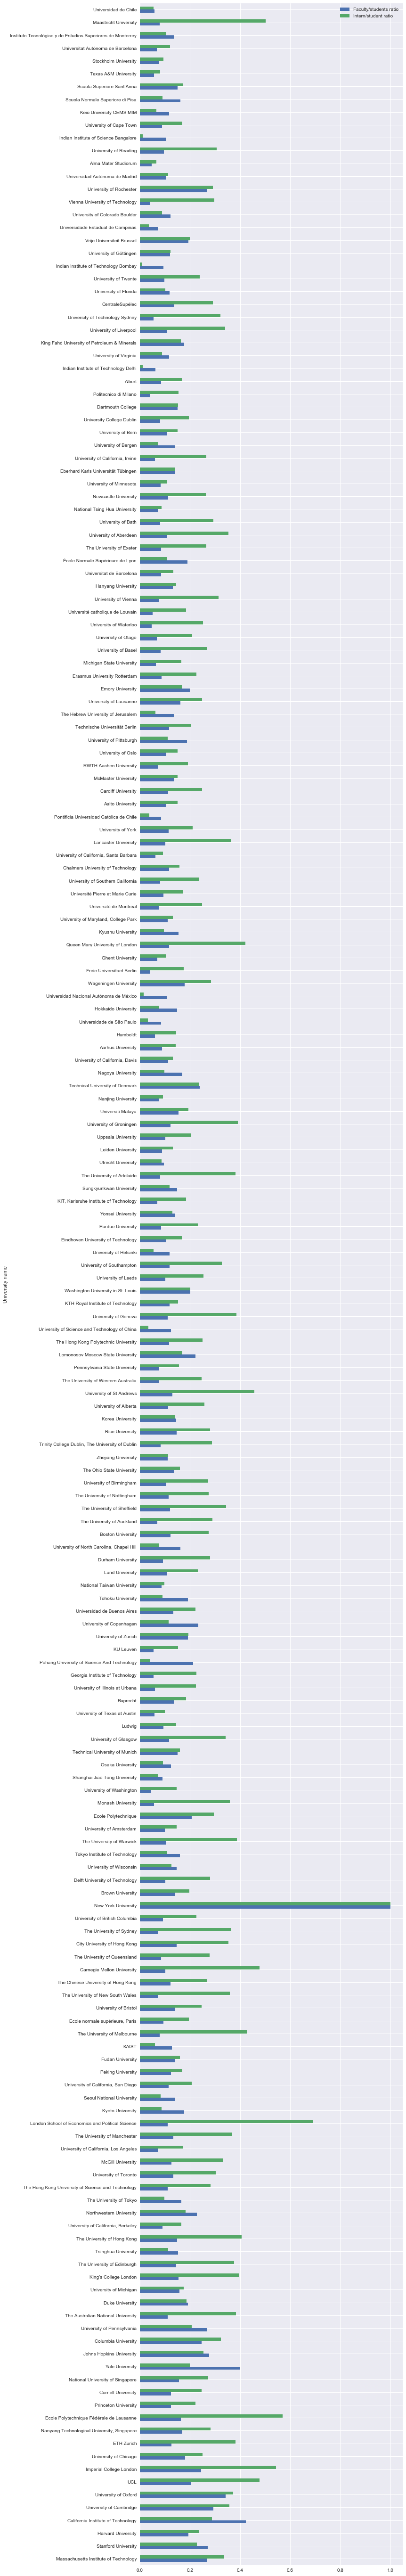

In [19]:
qs_ranking_df[['Faculty/students ratio', 'Intern/student ratio']].plot(kind='barh', figsize=(10,100))

Plot the results aggregating by region:

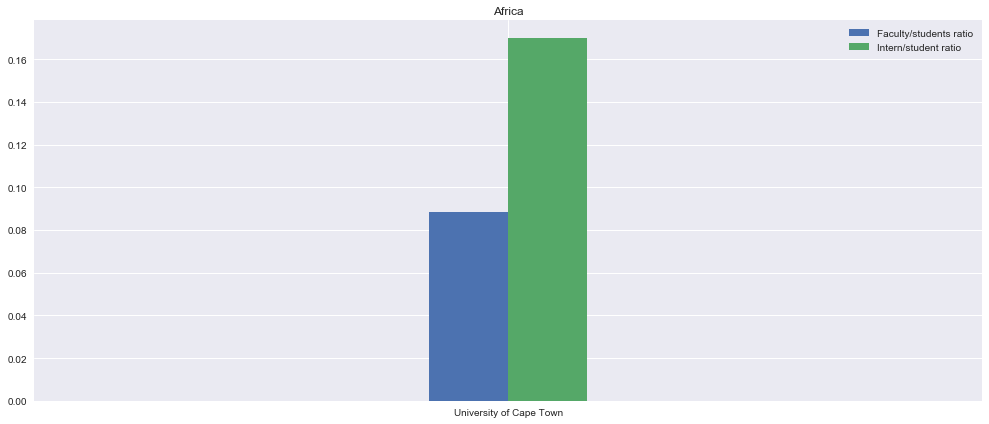

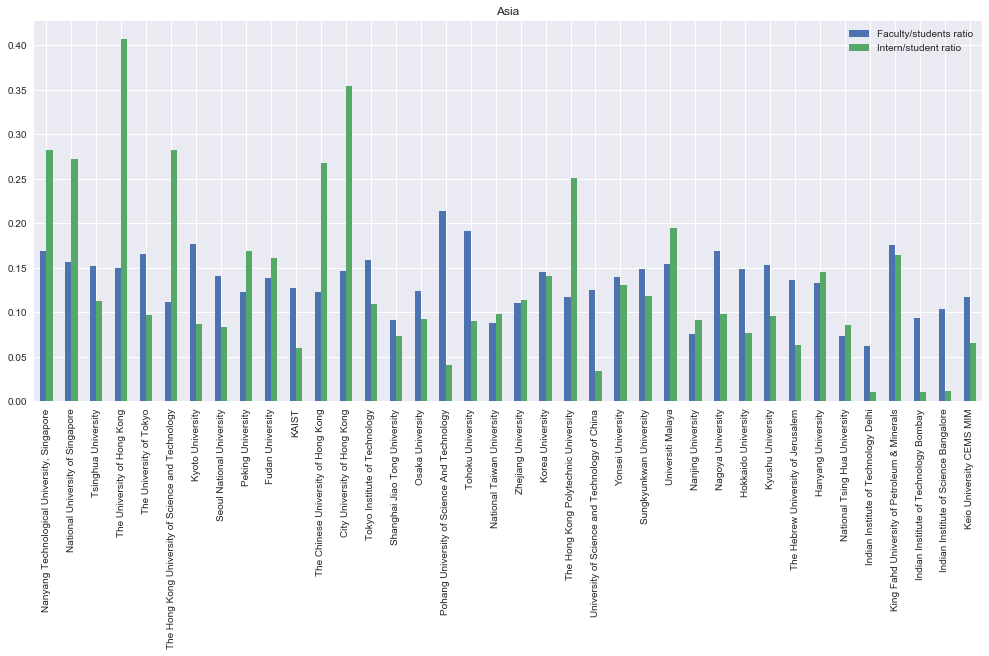

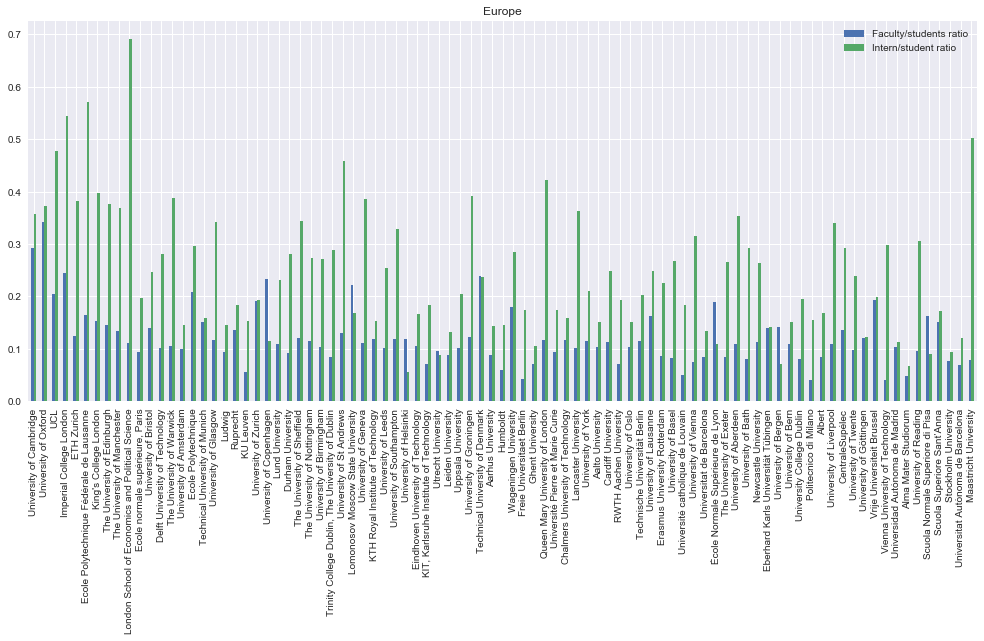

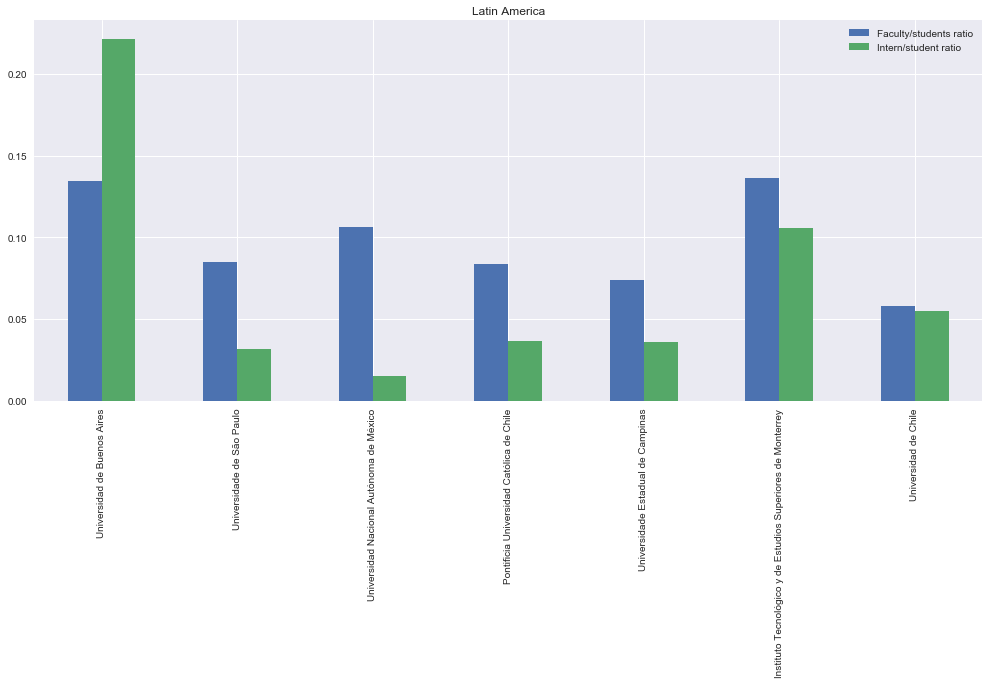

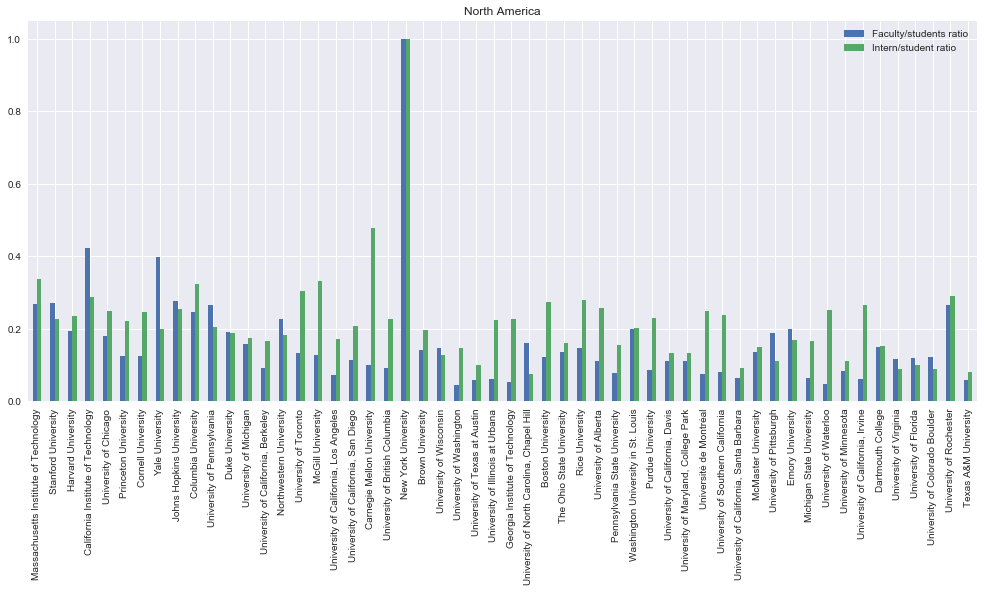

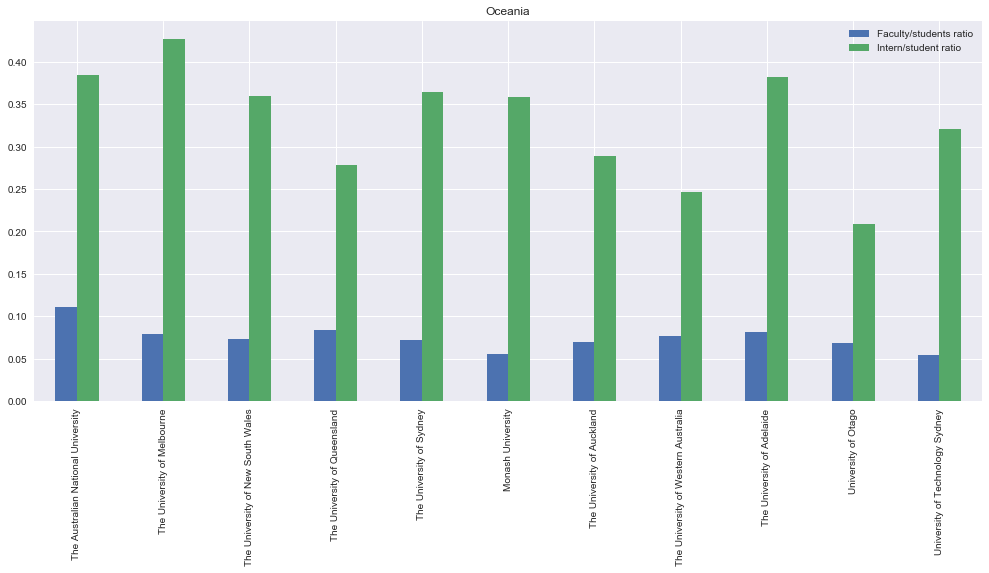

In [20]:
for i, (title, group) in enumerate(qs_ranking_df.groupby('Region')):
    ax = group[['Faculty/students ratio', 'Intern/student ratio']].plot.bar(figsize=(17, 7), 
                                                                            width= 0.5 if (len(group) > 2) else 0.1)
    plt.title(title)
    plt.xticks(rotation = 90 if (len(group) > 5) else 0)
    plt.xlabel("")
    plt.show()

Plot the results aggregating by country:

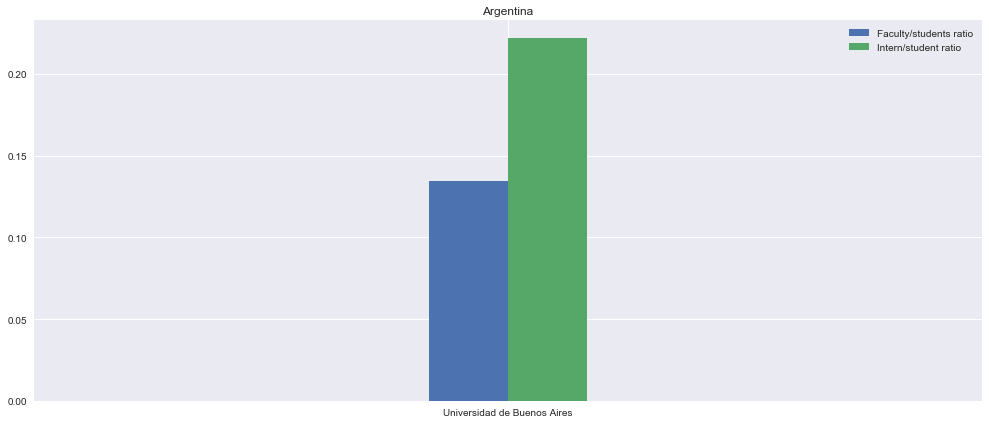

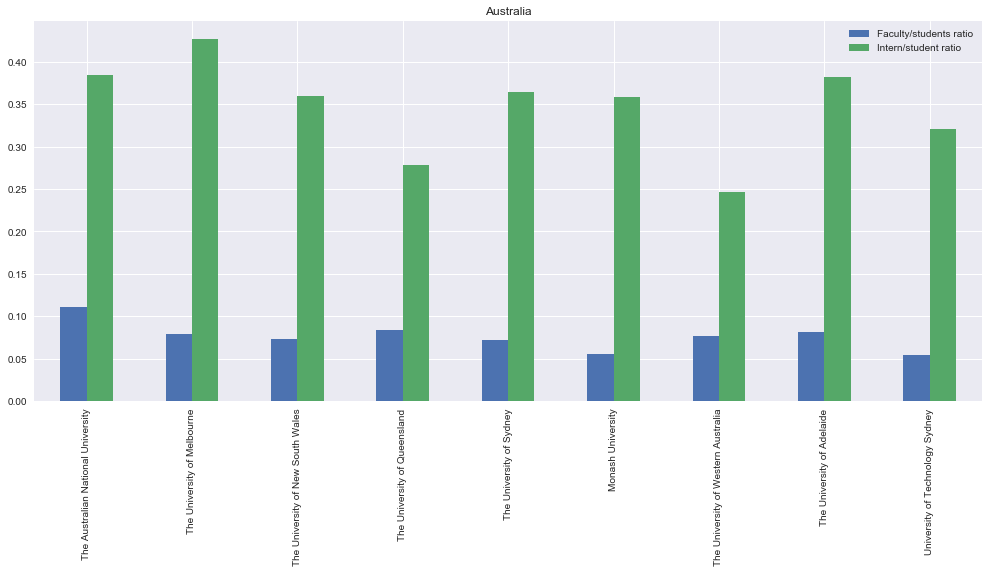

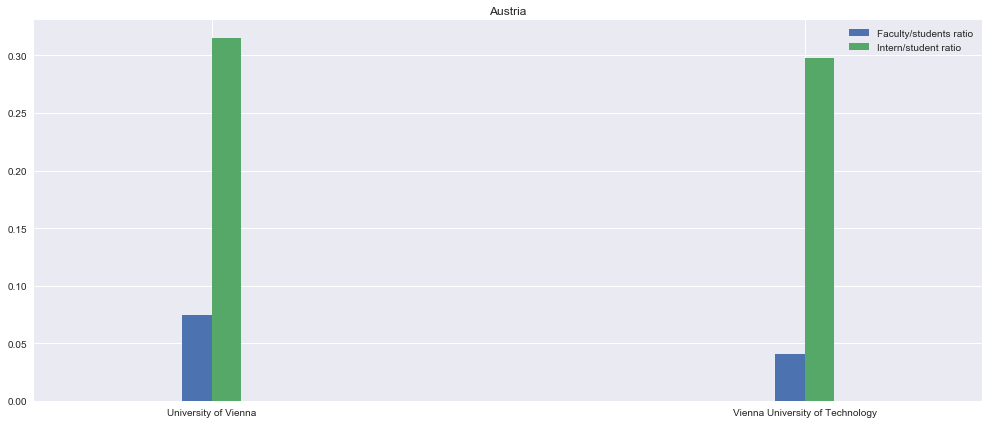

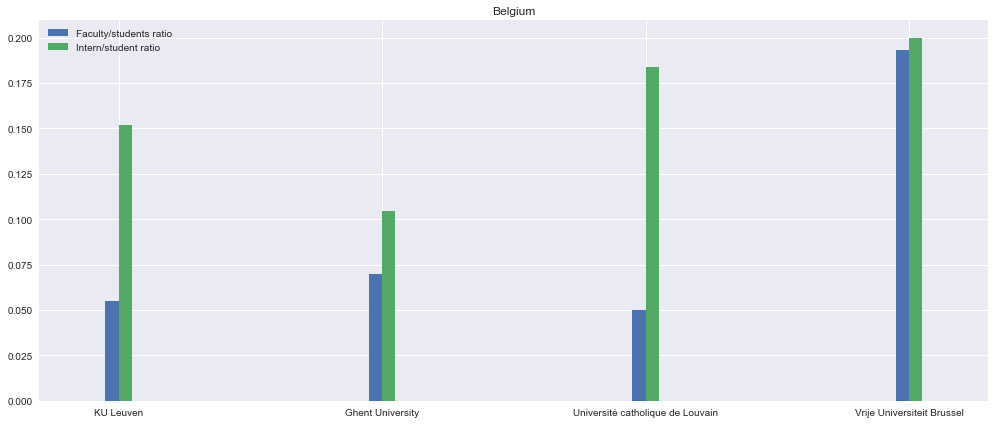

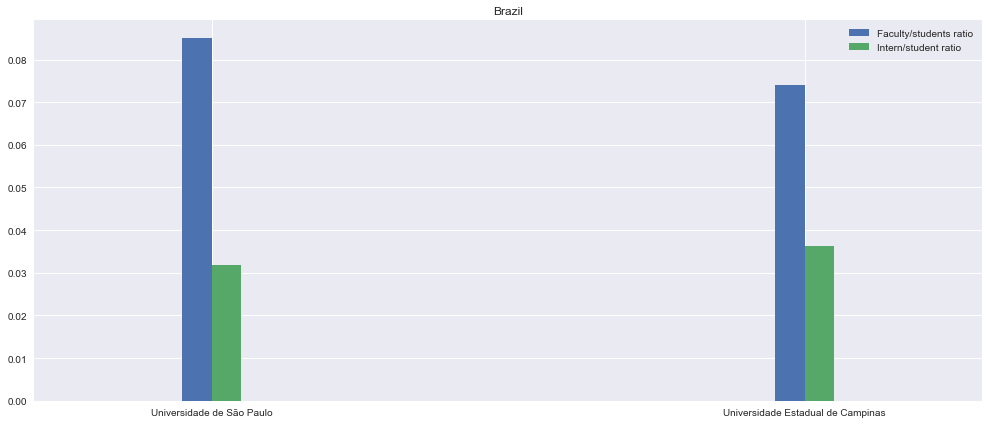

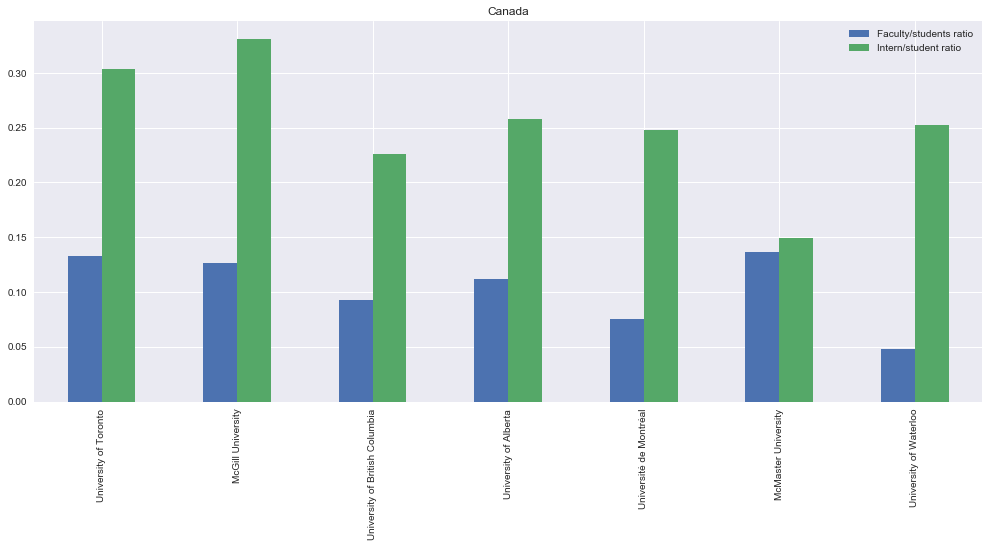

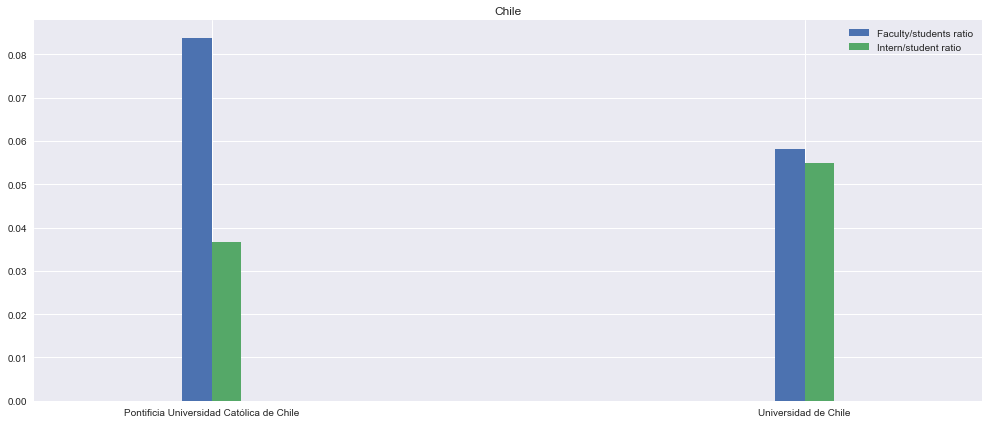

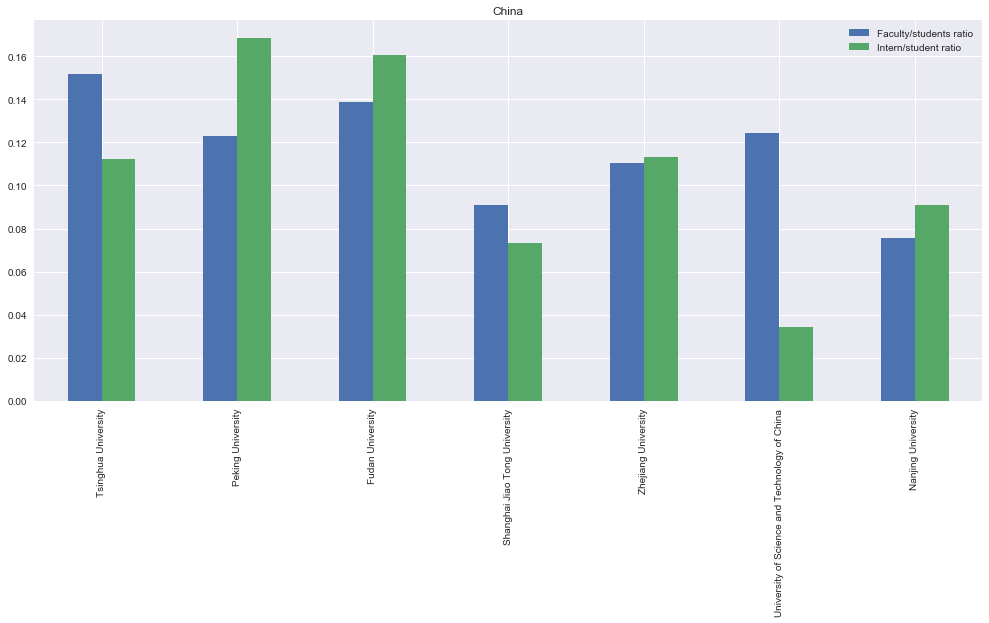

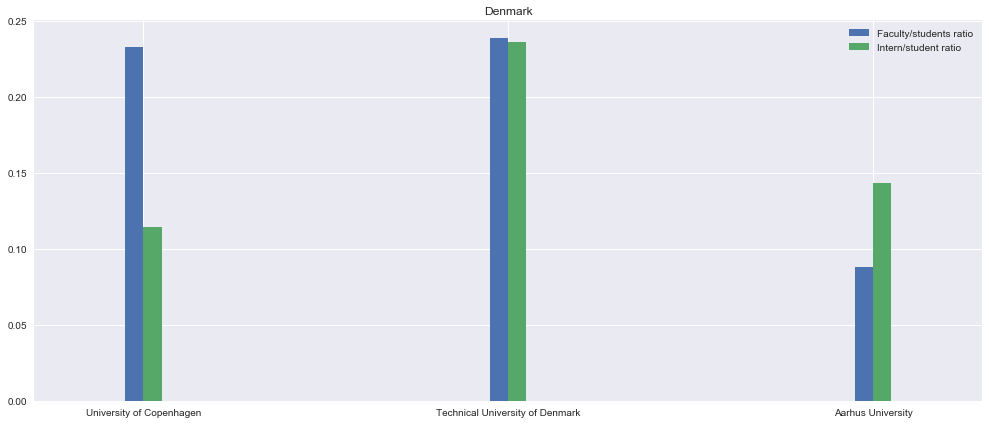

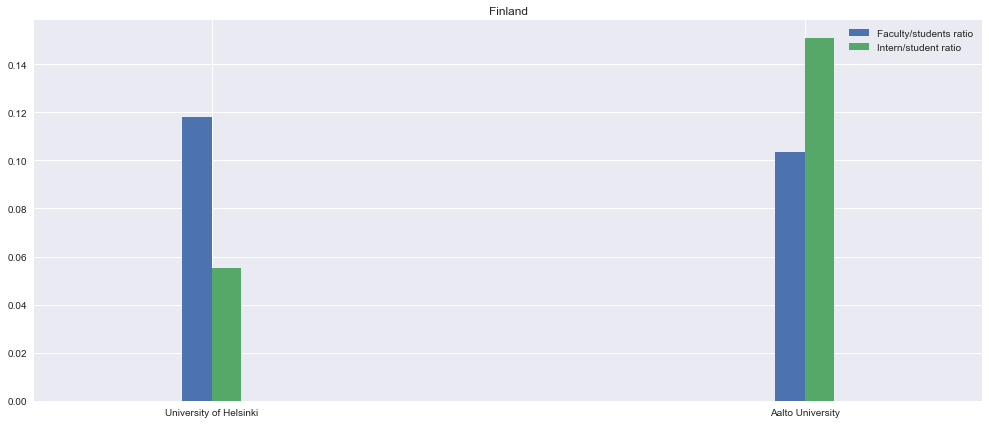

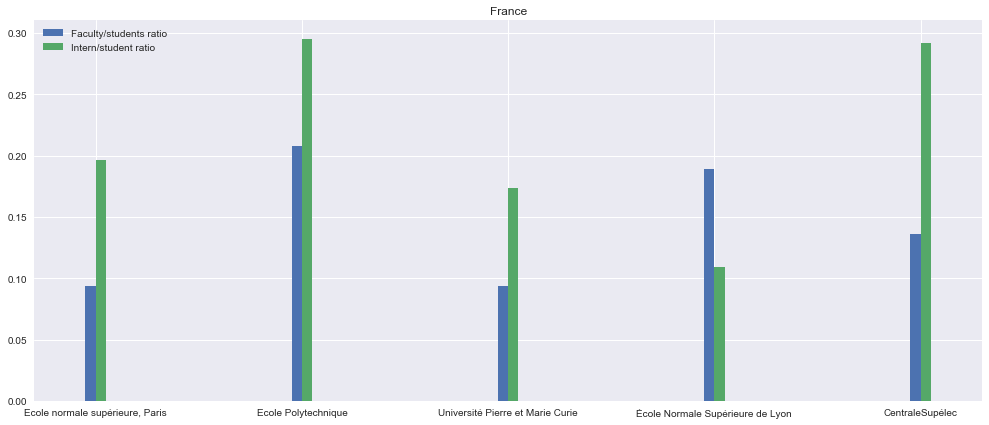

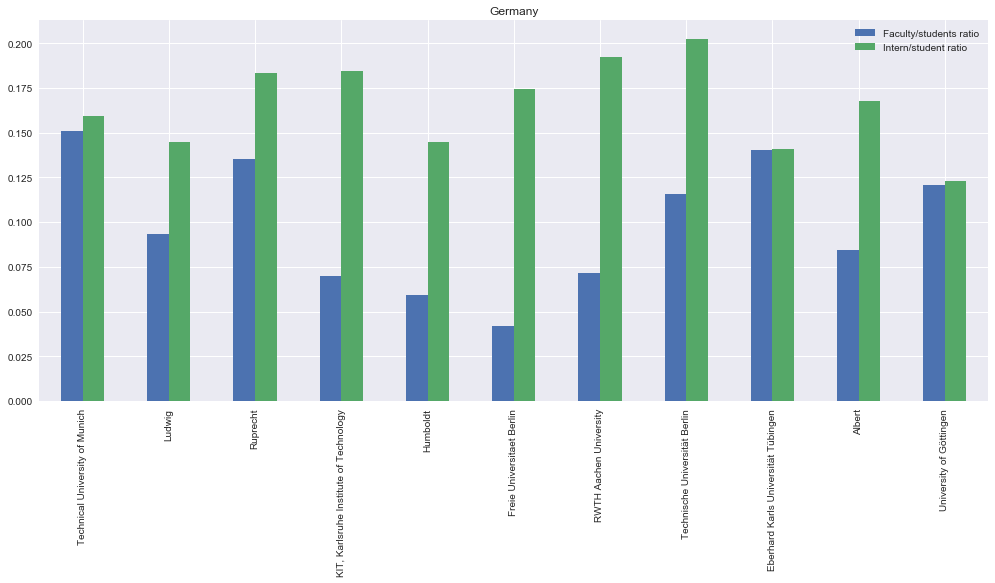

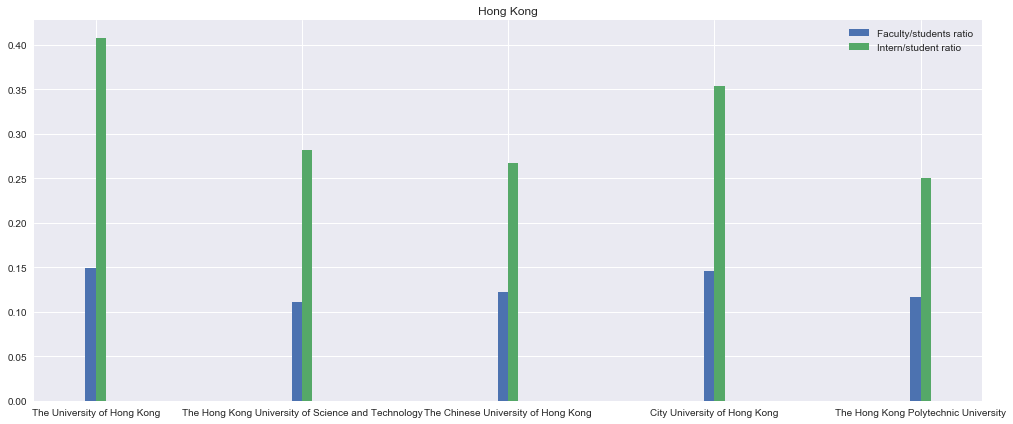

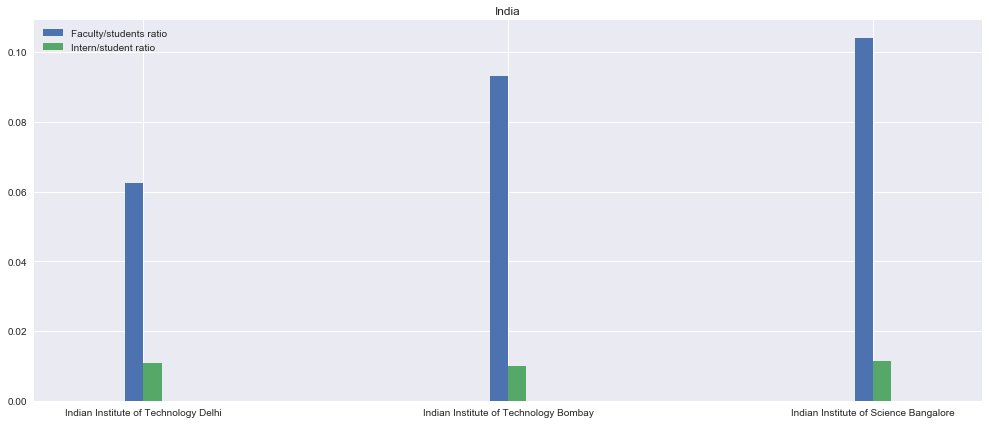

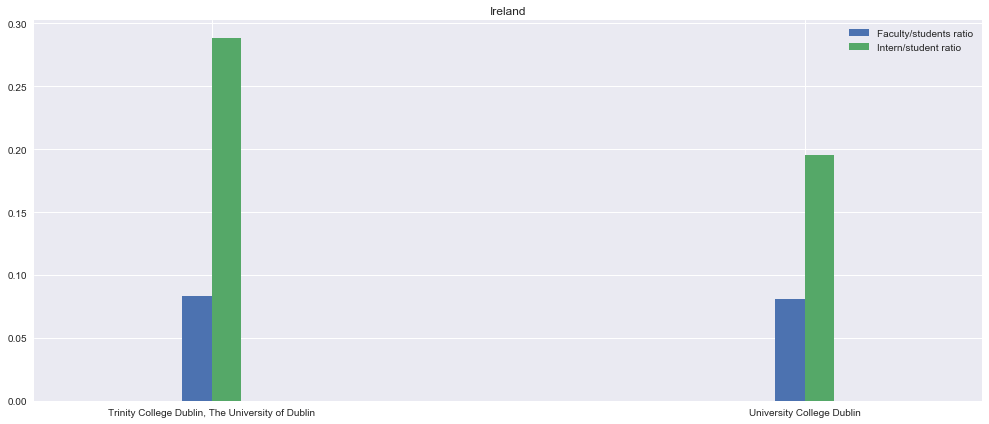

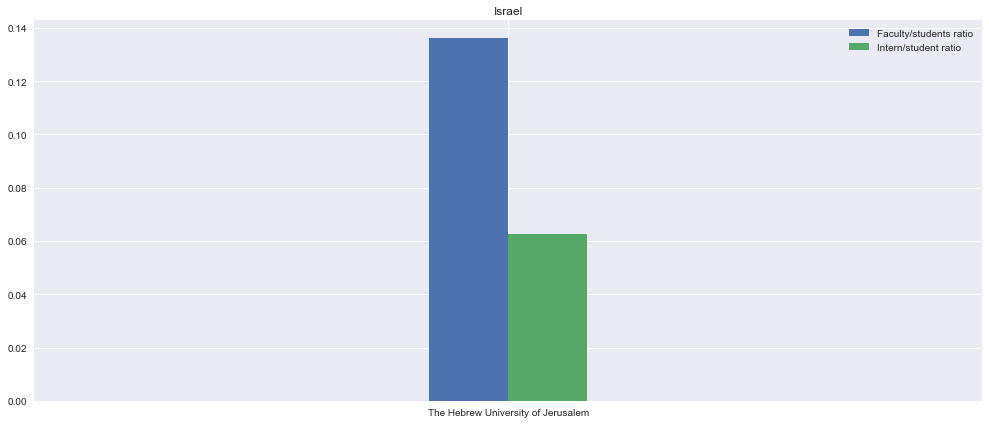

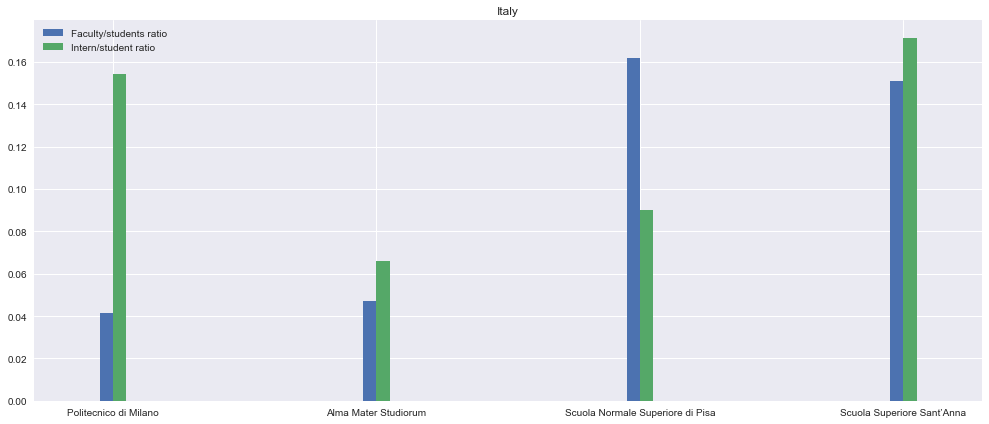

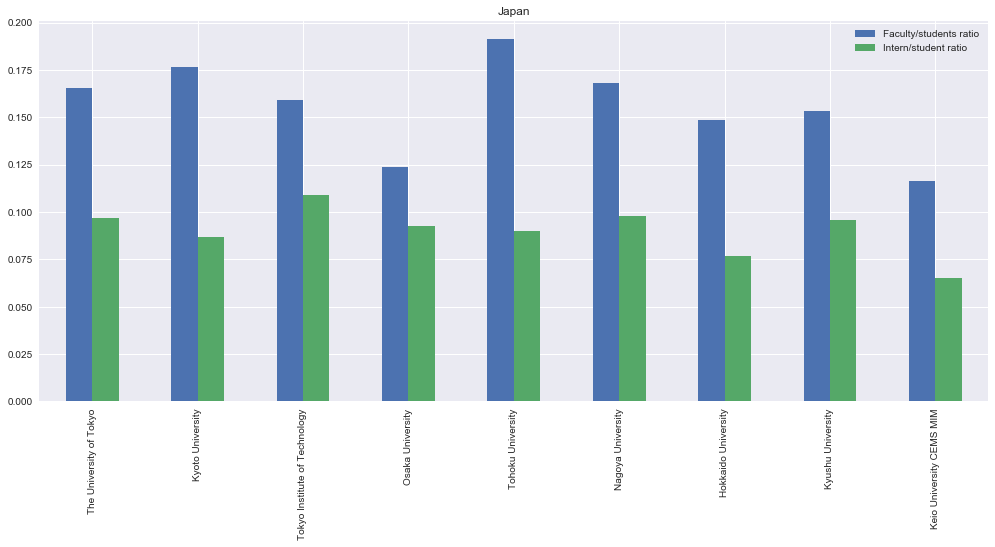

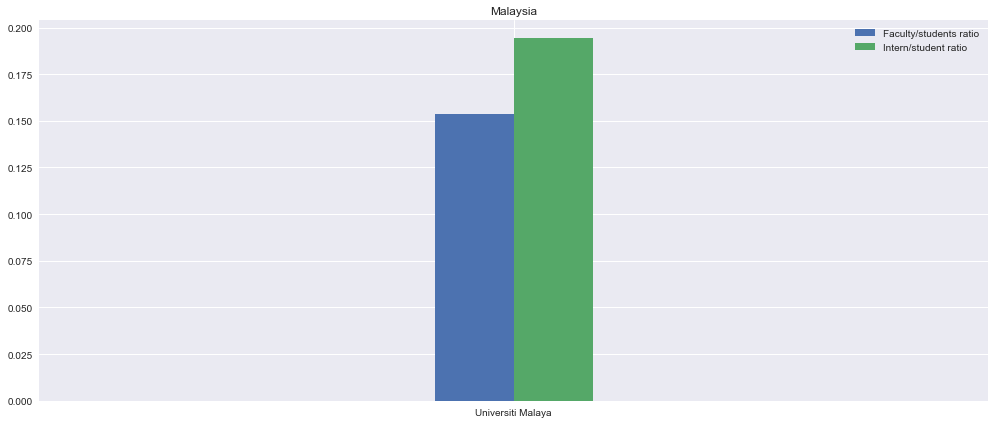

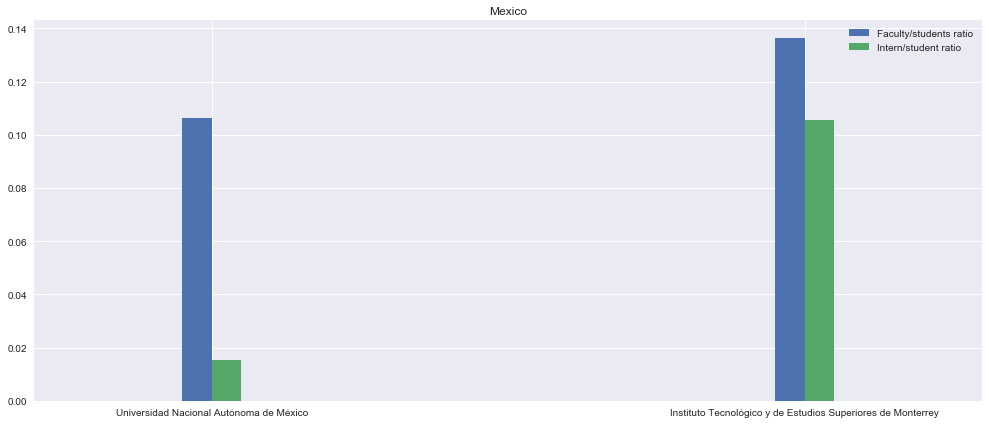

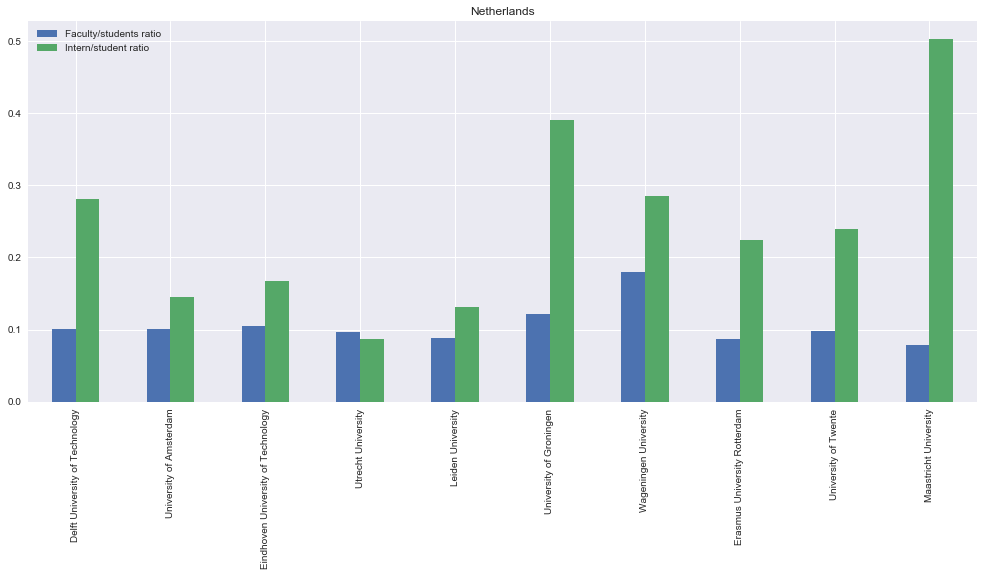

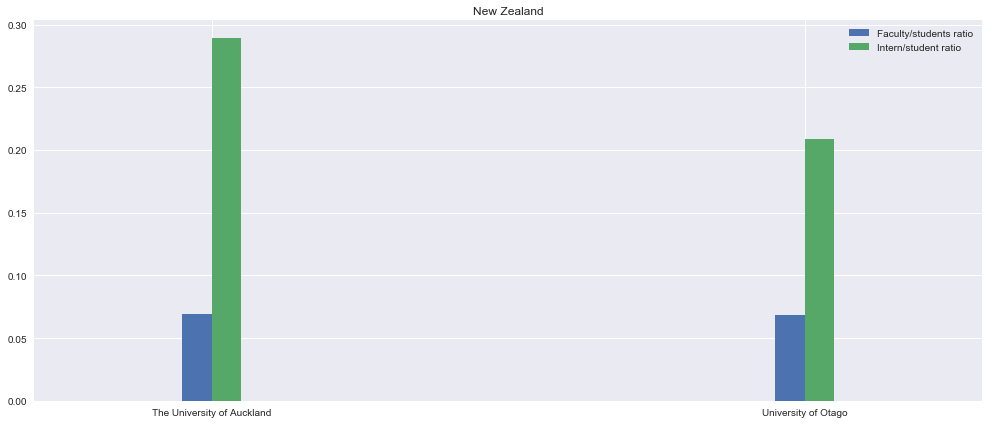

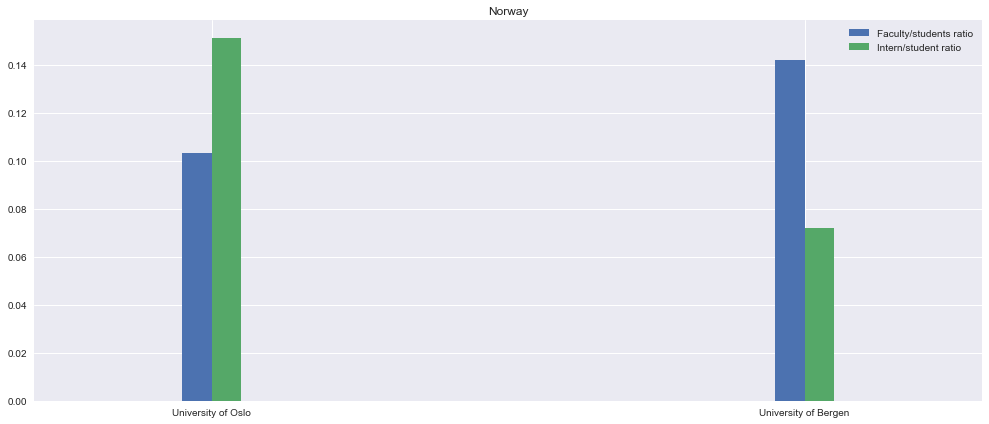

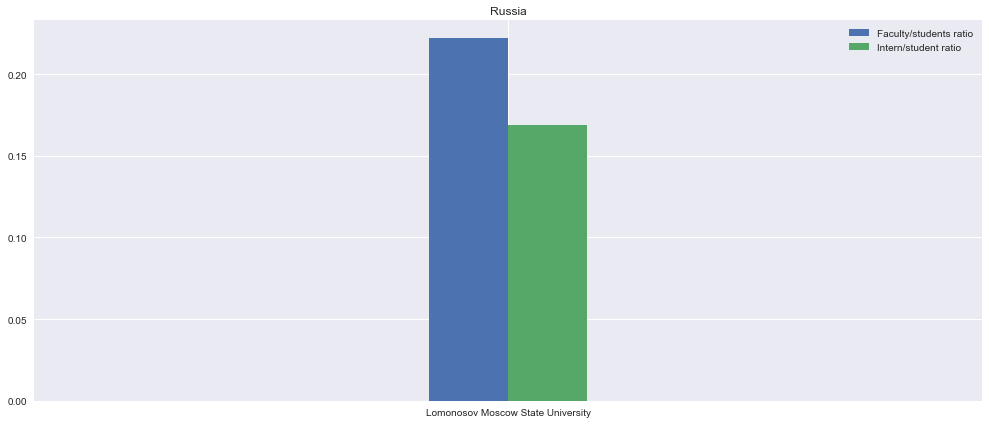

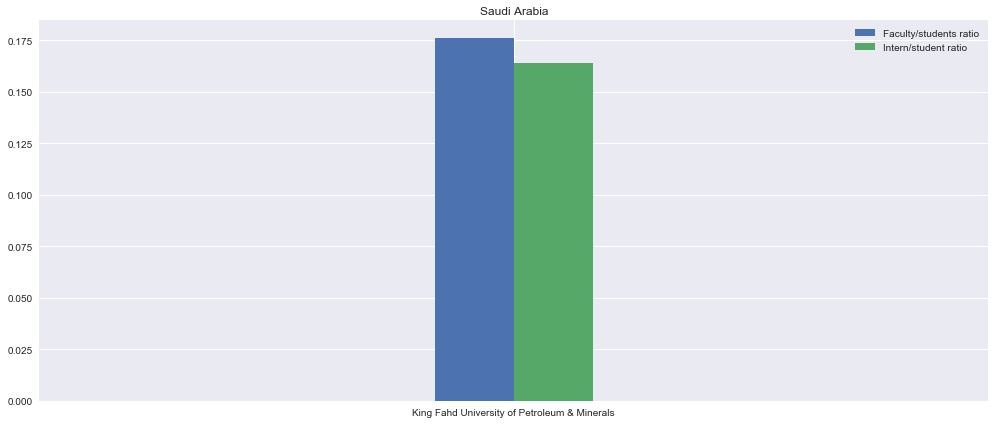

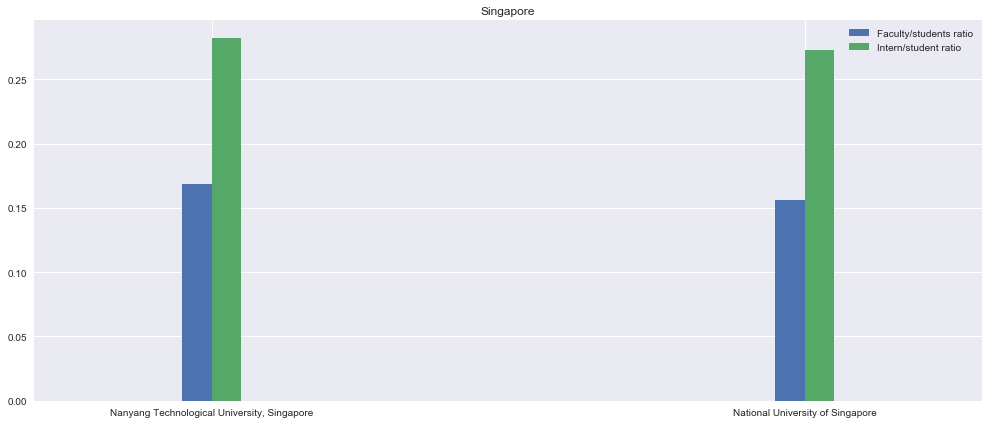

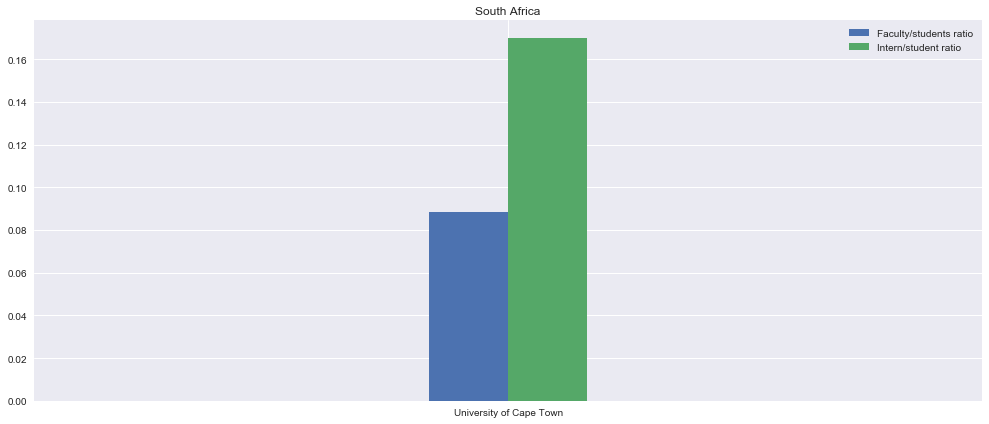

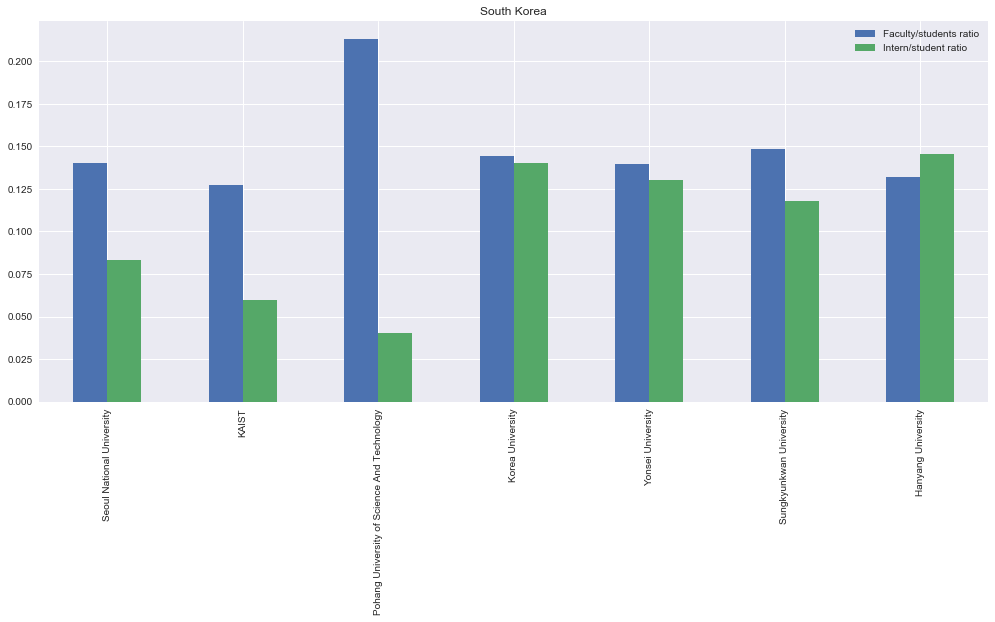

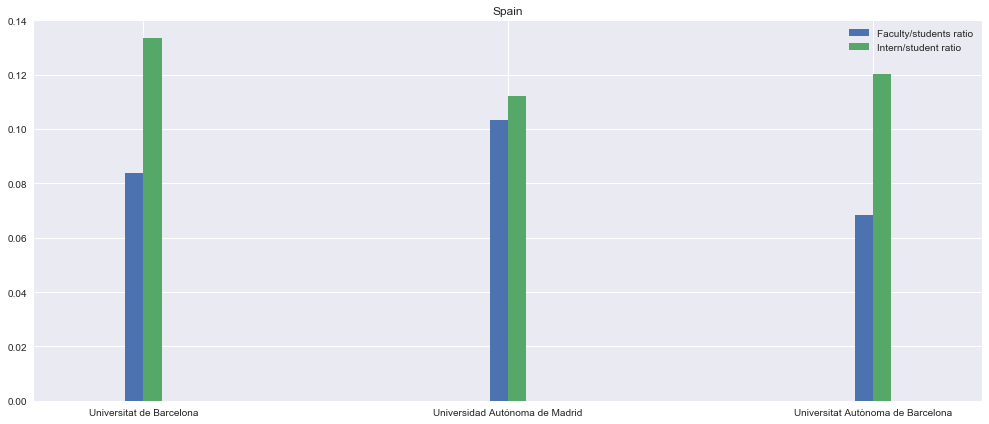

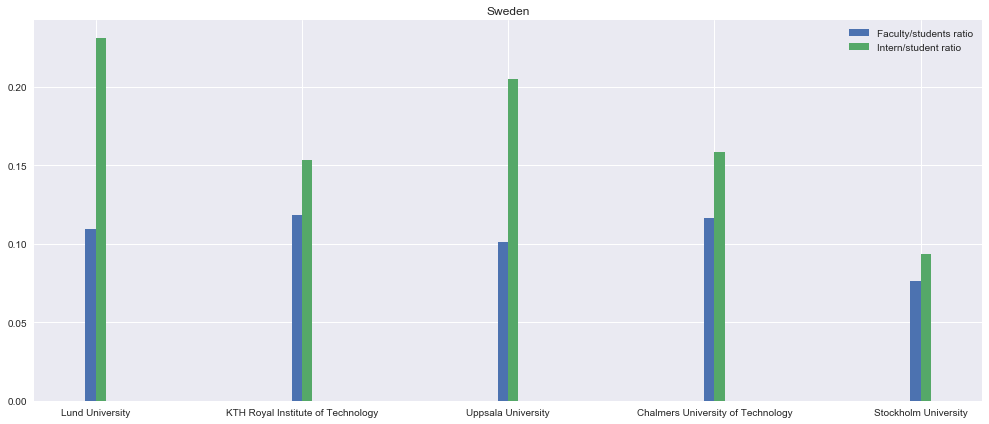

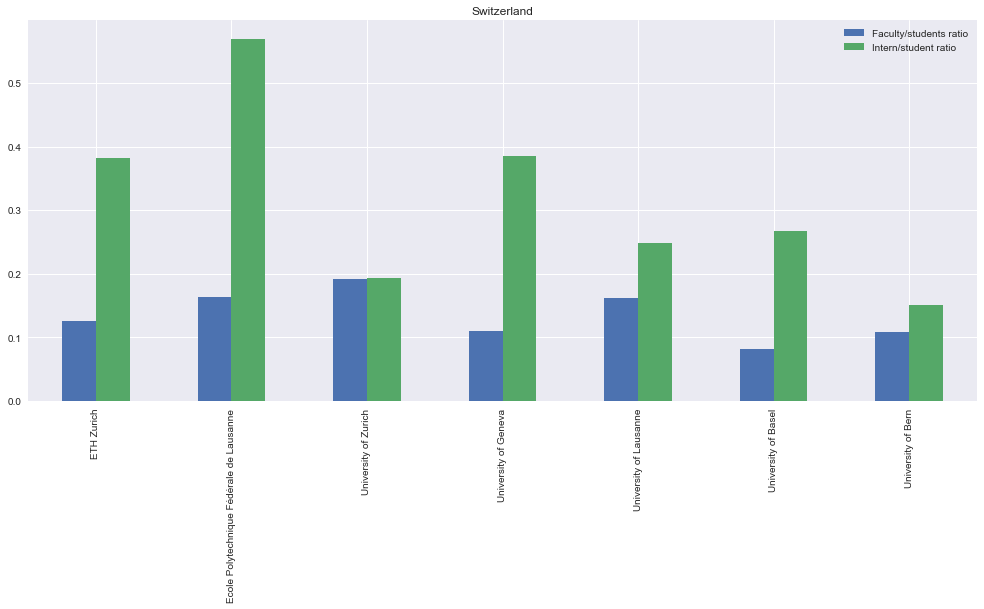

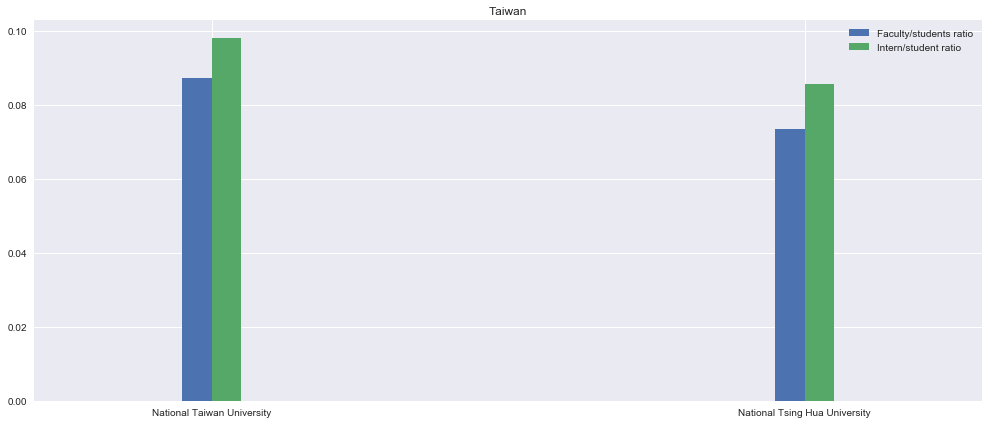

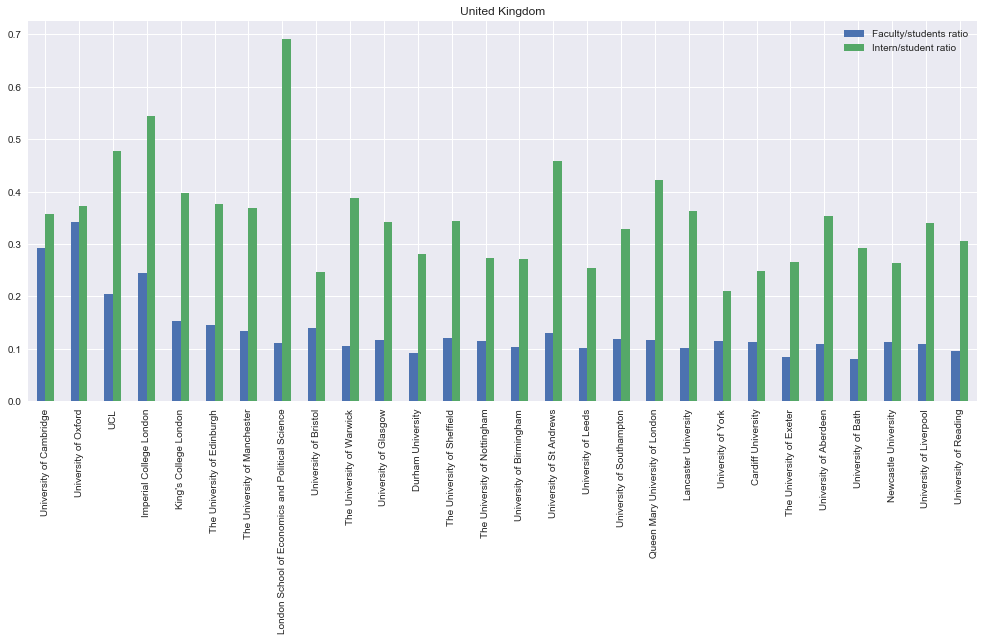

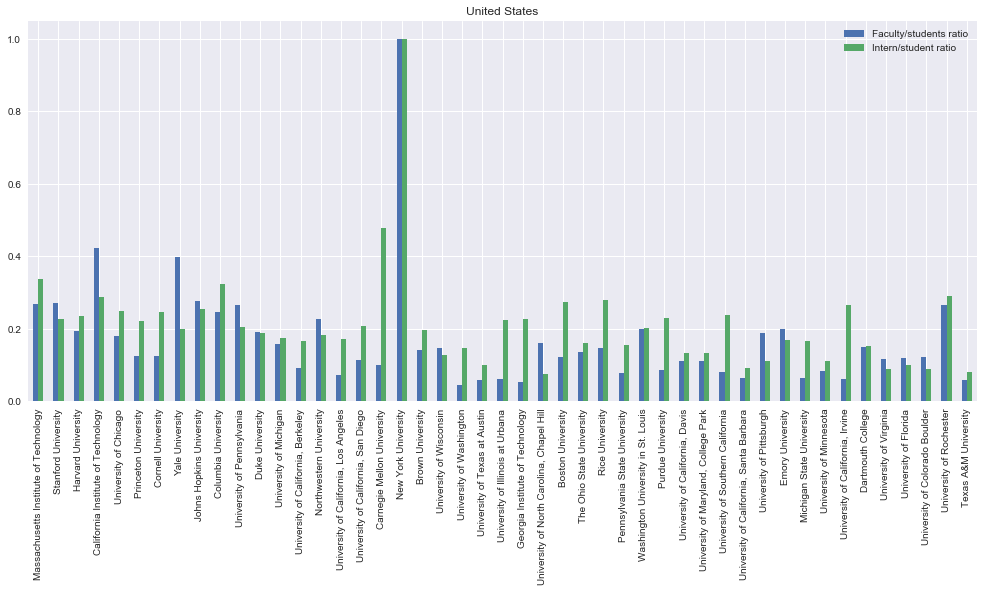

In [21]:
for i, (title, group) in enumerate(qs_ranking_df.groupby('Country')):
    ax = group[['Faculty/students ratio', 'Intern/student ratio']].plot.bar(figsize=(17, 7), 
                                                                            width= 0.5 if (len(group) > 5) else 0.1)
    plt.title(title)
    plt.xticks(rotation = 90 if (len(group) > 5) else 0)
    plt.xlabel("")
    plt.show()

### Task 2 - Scrape the Times ranking
Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

In [22]:
def compute_value_from_percentage(total, percentage):
    
    total = int( total )
    percentage = float( percentage )
    
    return round( (total/100) * percentage )

In [23]:
def compute_value_from_proportion(total, proportion):
    
    total = int( total )
    proportion = float( proportion )
    
    return round( total / proportion )

In [24]:
def scrape_times_ranking():
    '''
    Obtain the ranking from Times in a dataframe
    '''

    r = requests.get(TIMES_RANKING_JSON)
    data = r.json()

    university_list = []

    # Iterate throu the first 200 elments of the list
    for d in data['data'][:200]:
    
        # Preliminary computations to extract data
        intern_student = compute_value_from_percentage( clean_str_number( d['stats_number_students']), 
                                                       clean_str_number( d['stats_pc_intl_students'])
                                                      )
    
        faculty_member_total = compute_value_from_proportion( clean_str_number( d['stats_number_students']), 
                                                             clean_str_number( d['stats_student_staff_ratio'])
                                                            )
        
        # Determine region from the data of the QS ranking stored in the metadata
        try:
            region = COUNTRY_REGION_METADATA.get_value(d['location'], 'Region')
        except:
            region = 'NaN'
    
        # Store the parsed information into a dictionary
        info = {'Rank': d['rank'], 
                'University name': search_standard_name(d['name']), 
                'Country': d['location'],
                'Region' : region,
                'Total student' : int(clean_str_number( d['stats_number_students'])),
                'International student' : int(intern_student),
                'Total faculty member' : int(faculty_member_total)
               }
    
        university_list.append(info)
   
    times_ranking_df = pd.DataFrame.from_dict(university_list)
    return times_ranking_df

In [25]:
try:
    times_ranking_df = pd.read_pickle('serial/times_save.p')
except (OSError, IOError) as e:
    times_ranking_df = scrape_times_ranking()
    times_ranking_df.to_pickle('serial/times_save.p')
    
times_ranking_df.head()

,Country,International student,Rank,Region,Total faculty member,Total student,University name
0,United Kingdom,7755,1,Europe,1822,20409,University of Oxford
1,United Kingdom,6436,2,Europe,1687,18389,University of Cambridge
2,United States,596,=3,North America,340,2209,California Institute of Technology
3,United States,3486,=3,North America,2113,15845,Stanford University
4,United States,3800,5,North America,1285,11177,Massachusetts Institute of Technology


Missig data:

In [26]:
times_ranking_df.set_index(['University name'], inplace=True)

#### Which are the best universities in term of ratio between faculty members and students?

In [ ]:
#times_ranking_df['Faculty/students ratio'] = compute_facutly_member_ratio( qs_ranking_df )

#### Which are the best universities in term of ratio of international students?

In [45]:
times_ranking_df['Intern/student ratio'] = times_ranking_df['International student'] / times_ranking_df['Total student']

international_students_rank_df = times_ranking_df[['Country', 'Region', 'International student', 'Total student', 'Intern/student ratio']]
international_students_rank_df = international_students_rank_df.sort_values('Intern/student ratio', ascending=False)

international_students_rank_df.head()

,Country,Region,International student,Total student,Intern/student ratio
University name,,,,,
London School of Economics and Political Science,United Kingdom,Europe,7146,10065,0.709985
University of Luxembourg,Luxembourg,NaN,2832,4969,0.569934
Imperial College London,United Kingdom,Europe,8721,15857,0.549978
École Polytechnique Fédérale de Lausanne,Switzerland,Europe,5460,9928,0.549960
Maastricht University,Netherlands,Europe,8364,16727,0.500030


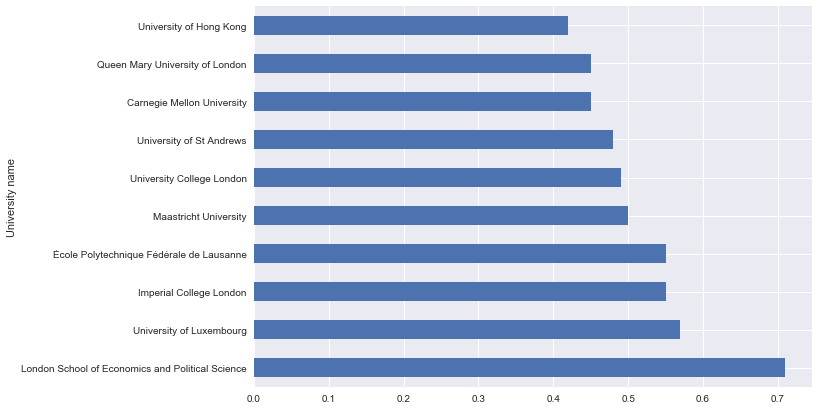

In [46]:
international_students_rank_df[:10]['Intern/student ratio'].plot(kind='barh', figsize=(10,7))

Plot all the computed data: (?)

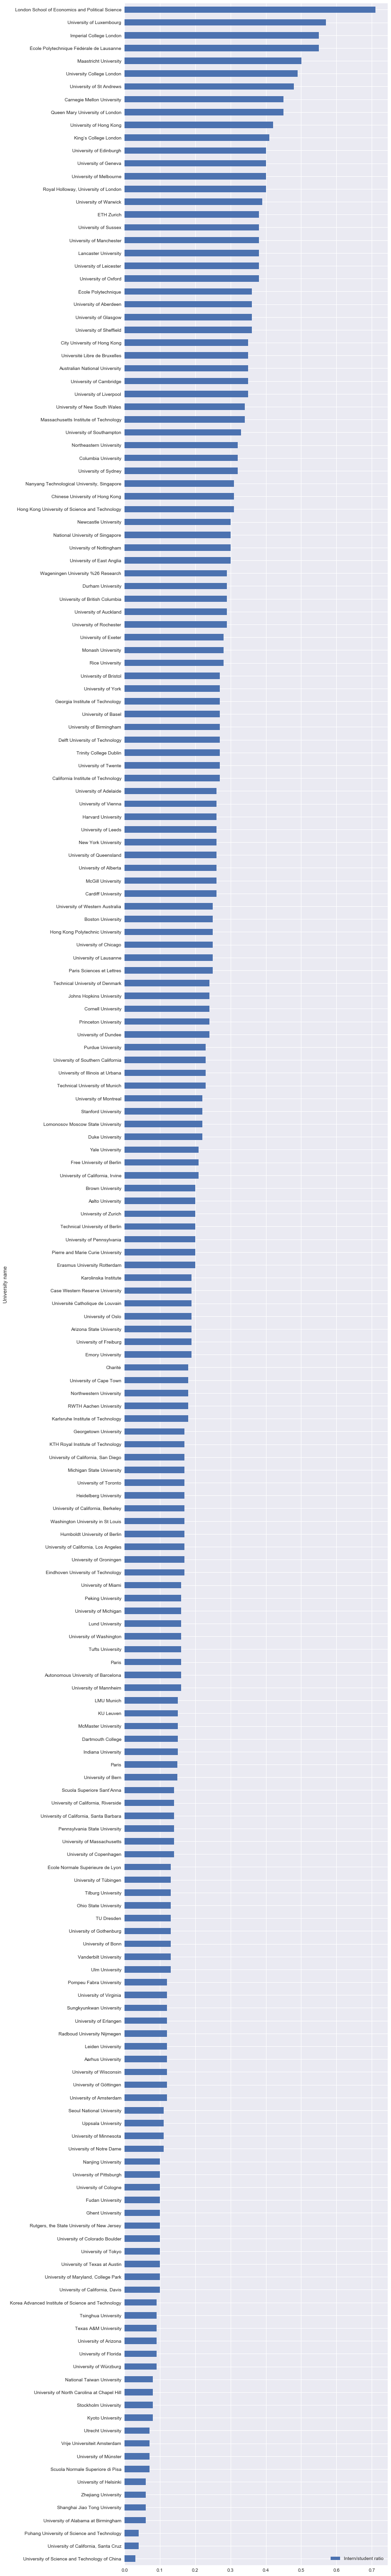

In [28]:
times_ranking_df.sort_values('Intern/student ratio')[['Intern/student ratio']].plot( kind='barh', figsize=(10,100))

Plot the results aggregating by region:

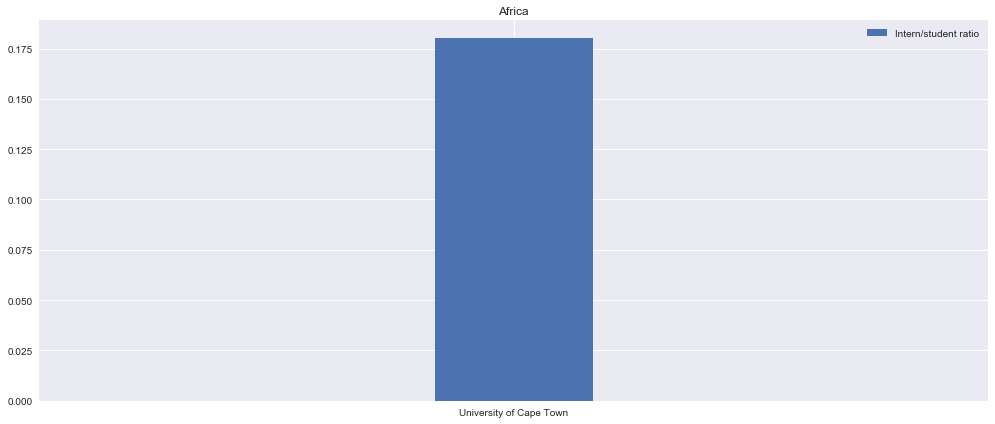

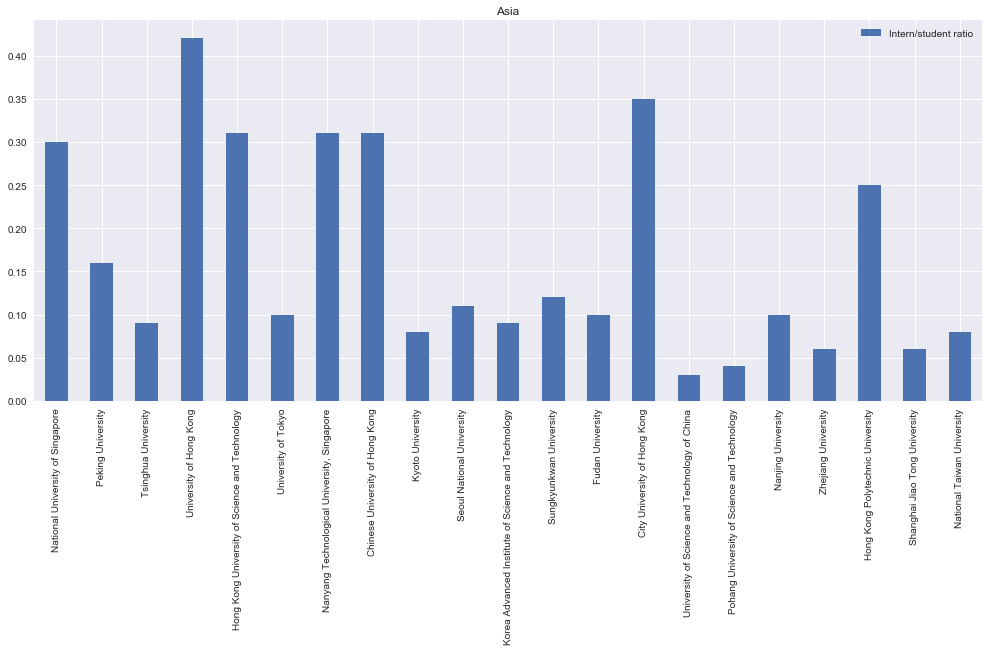

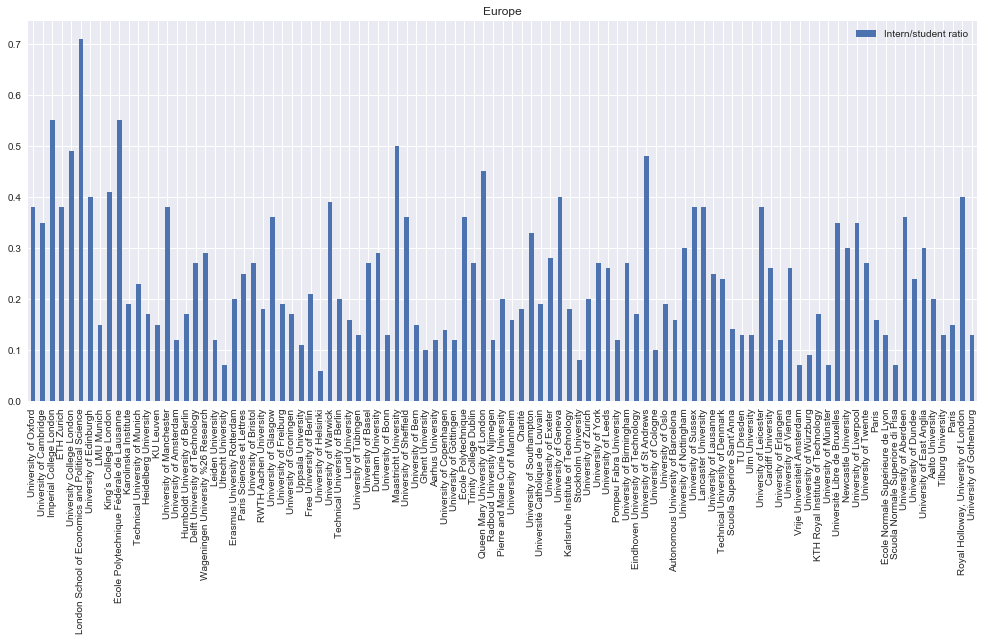

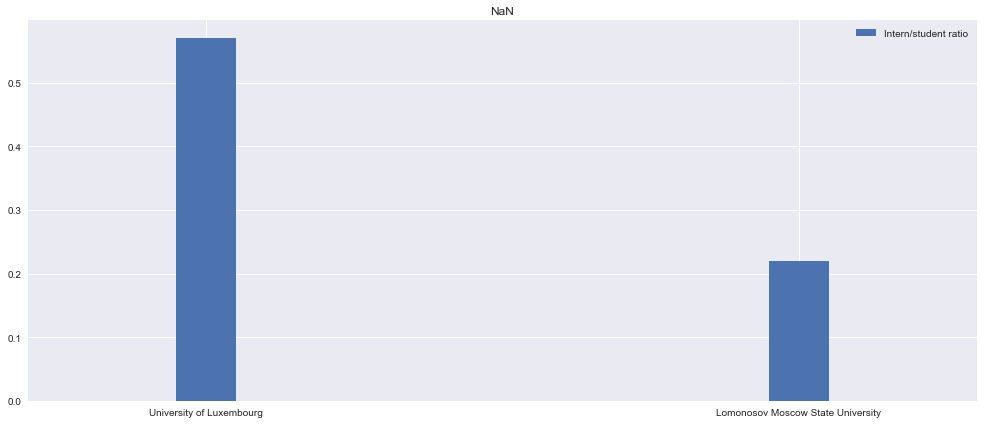

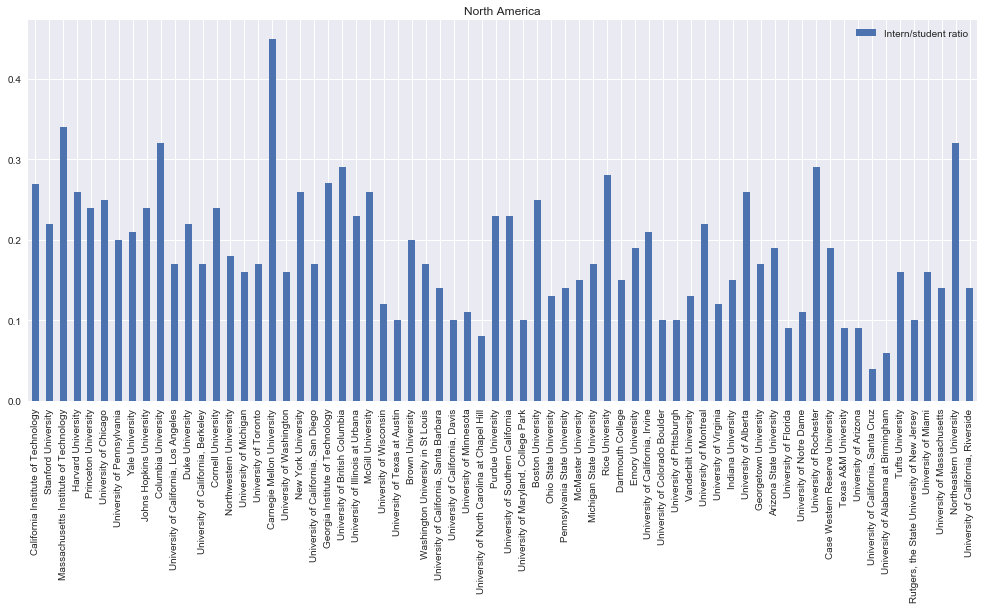

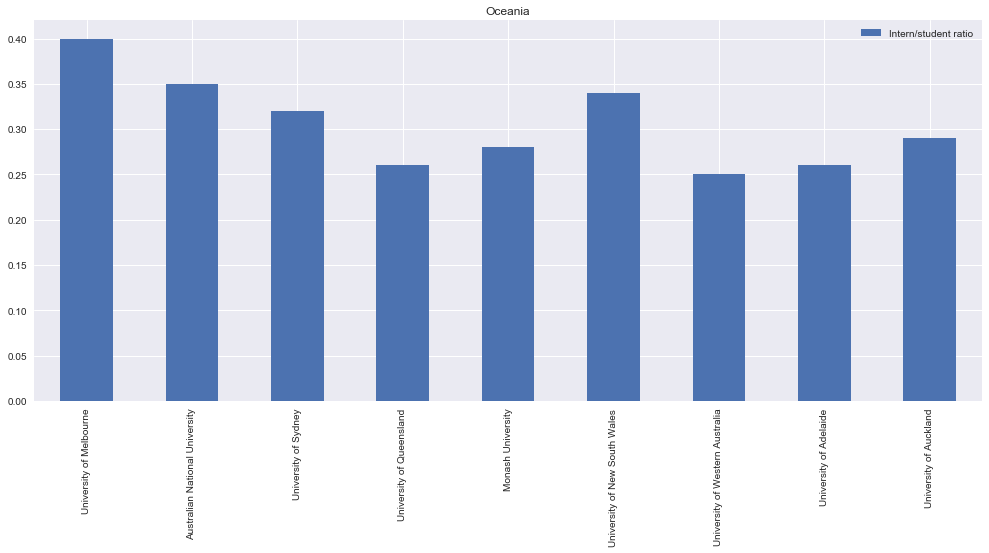

In [29]:
for i, (title, group) in enumerate(times_ranking_df.groupby('Region')):
    ax = group[['Intern/student ratio']].plot.bar(figsize=(17, 7), 
                                                  width= 0.5 if (len(group) > 2) else 0.1)
    plt.title(title)
    plt.xticks(rotation = 90 if (len(group) > 5) else 0)
    plt.xlabel("")
    plt.show()

Plot the results aggregating by country:

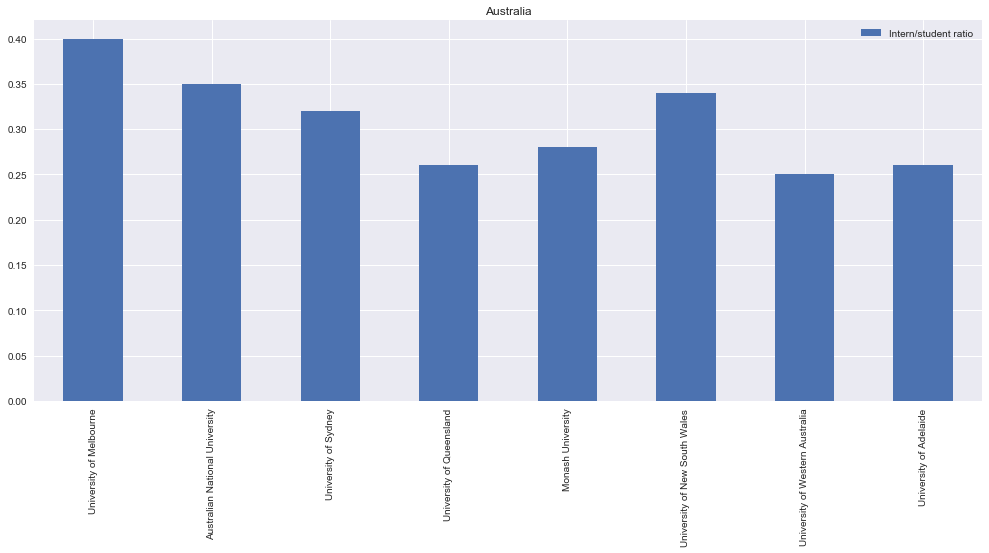

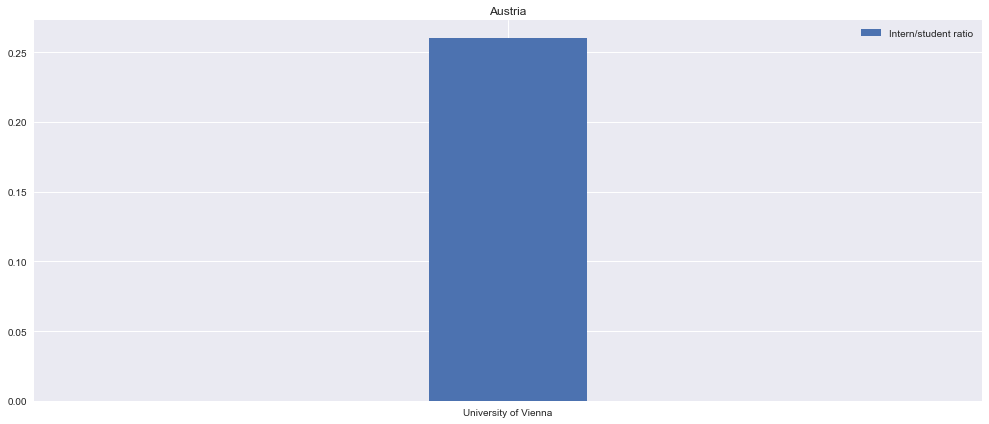

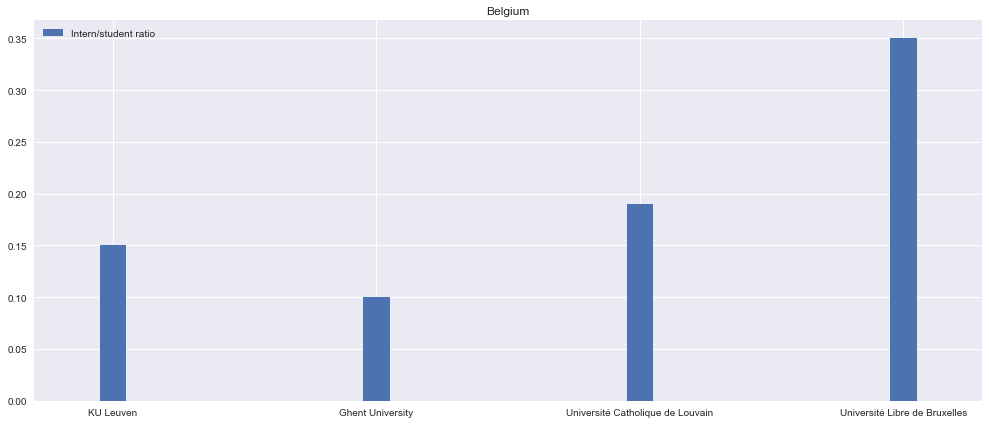

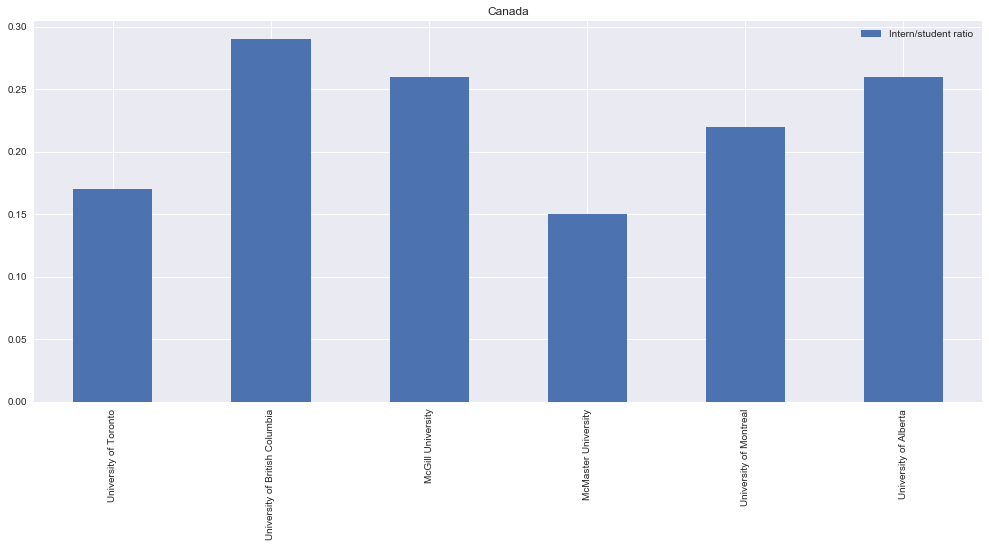

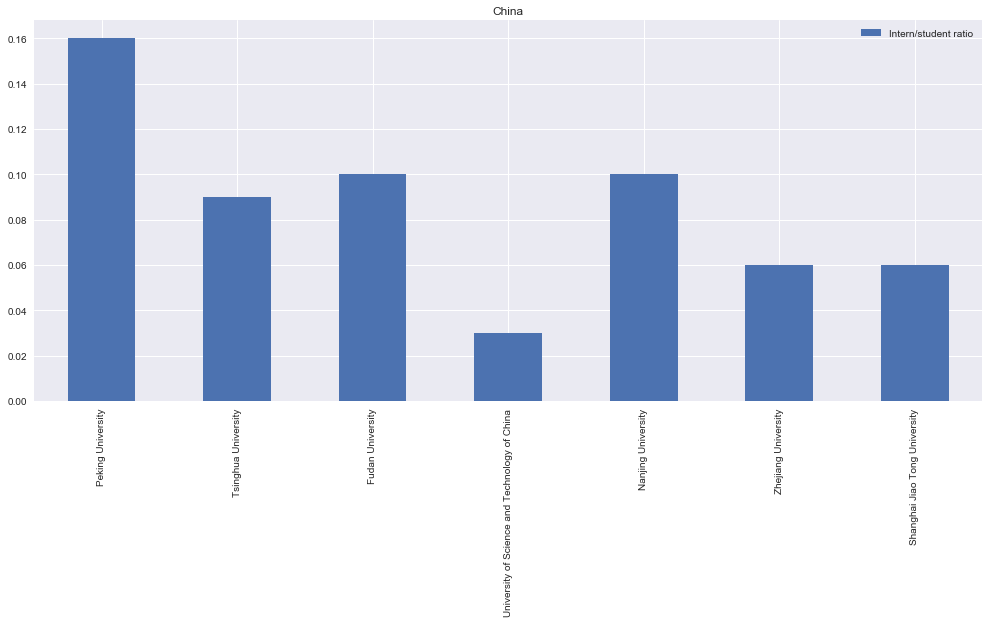

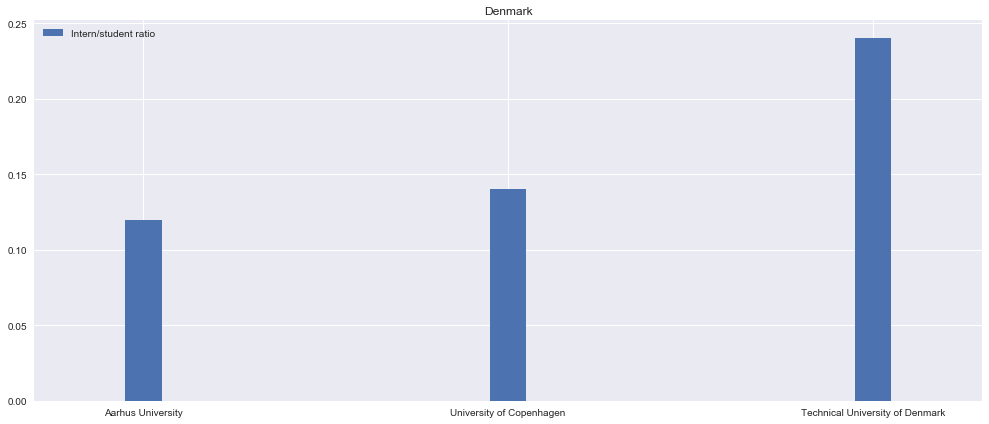

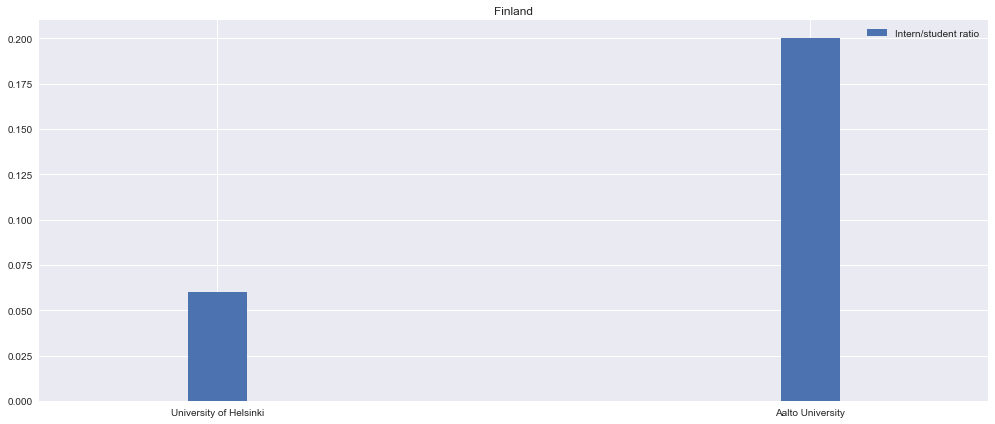

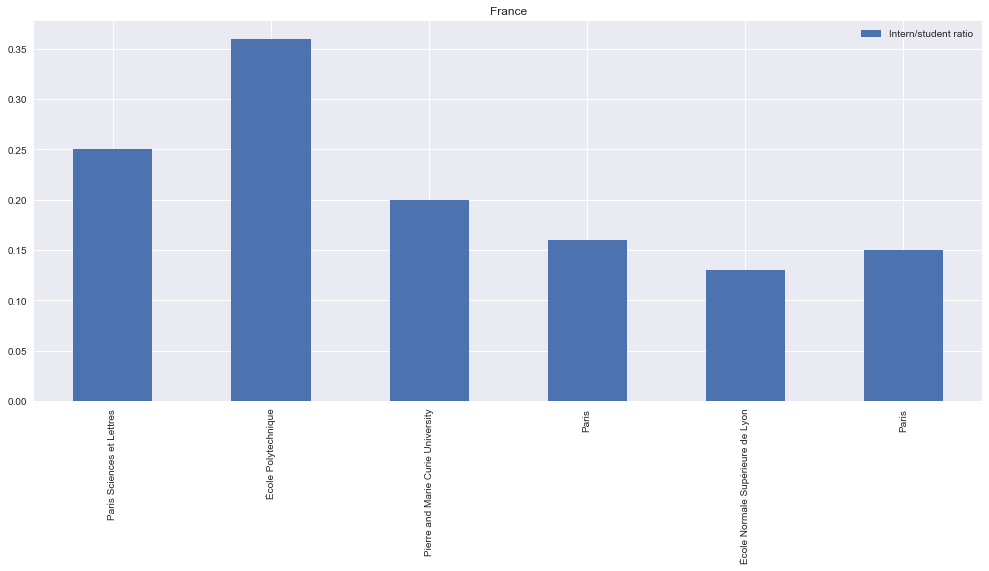

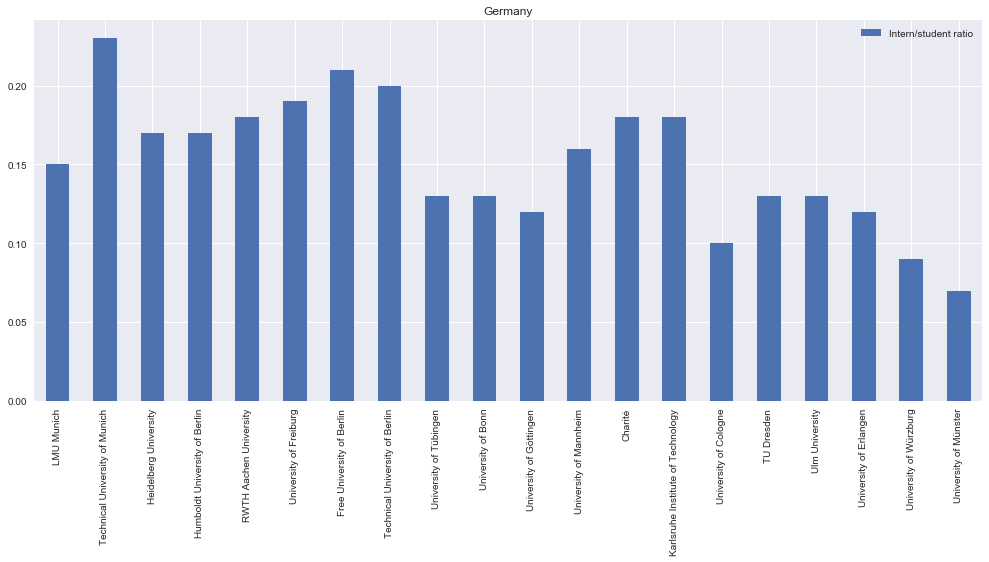

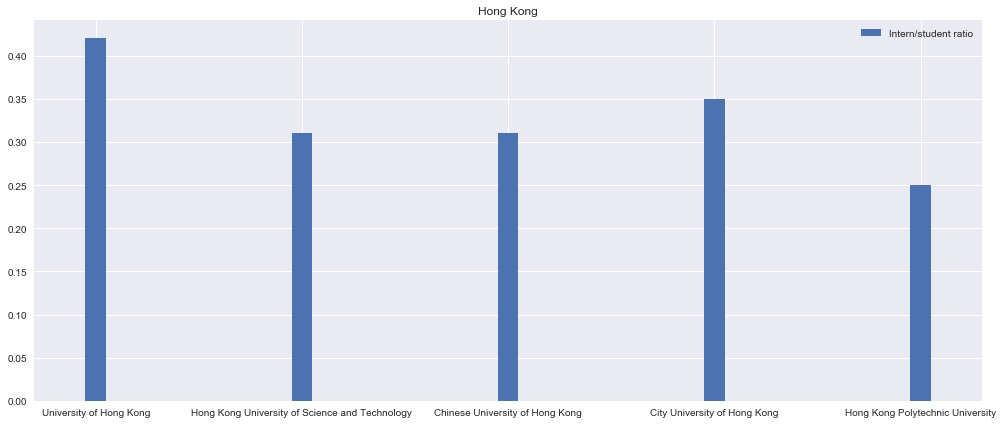

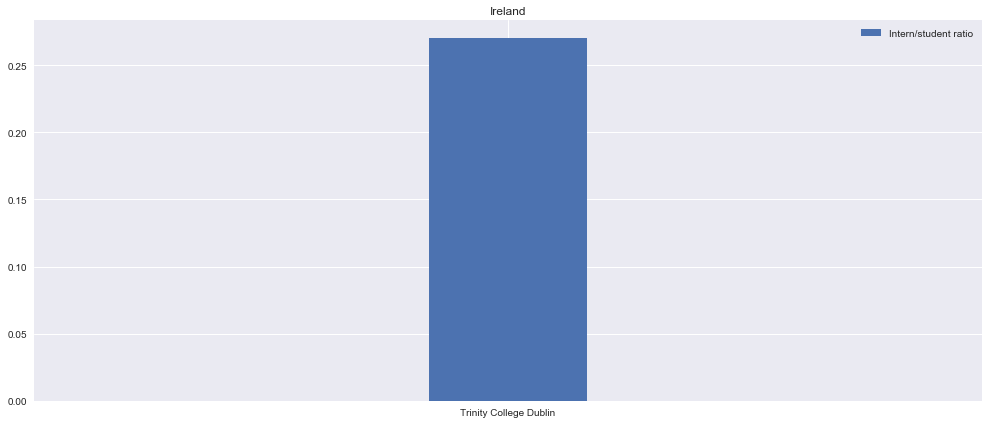

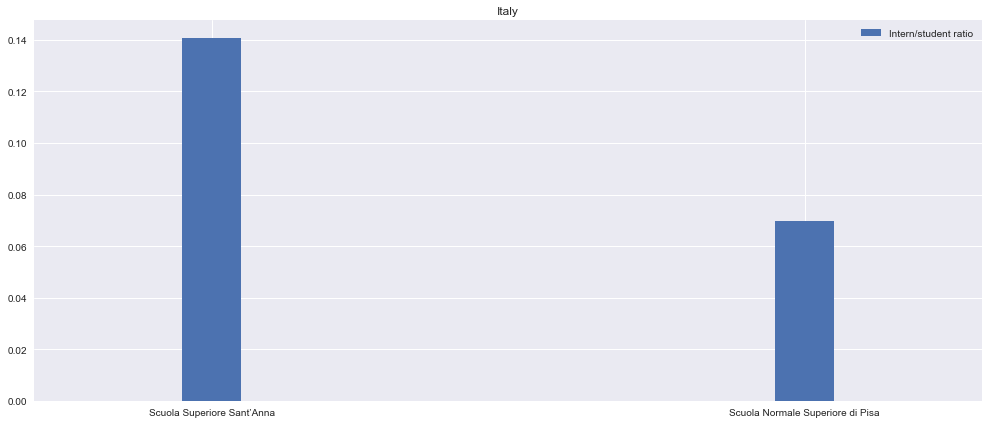

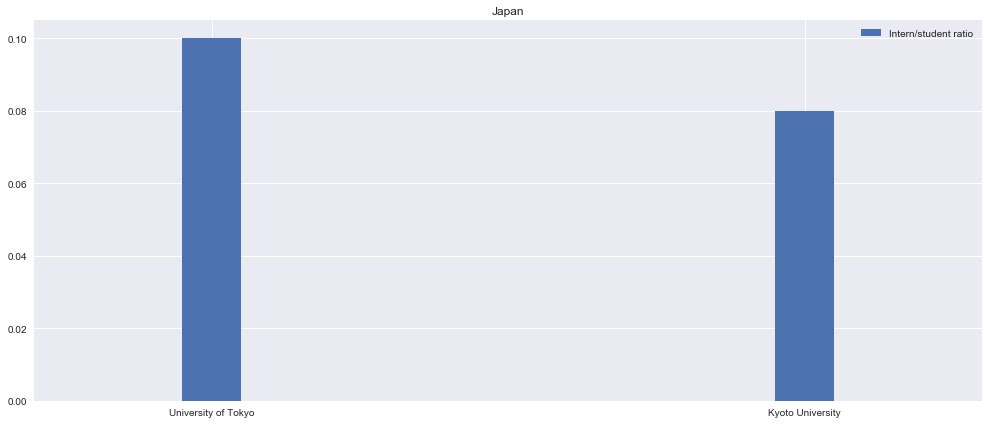

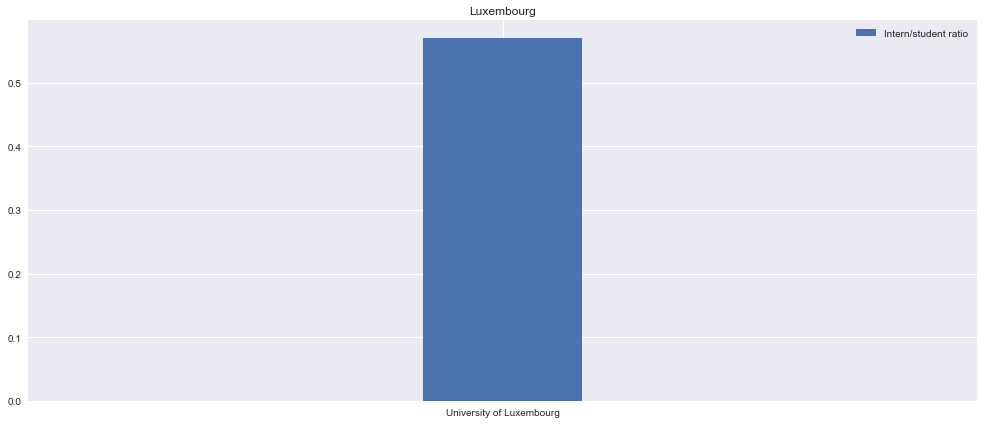

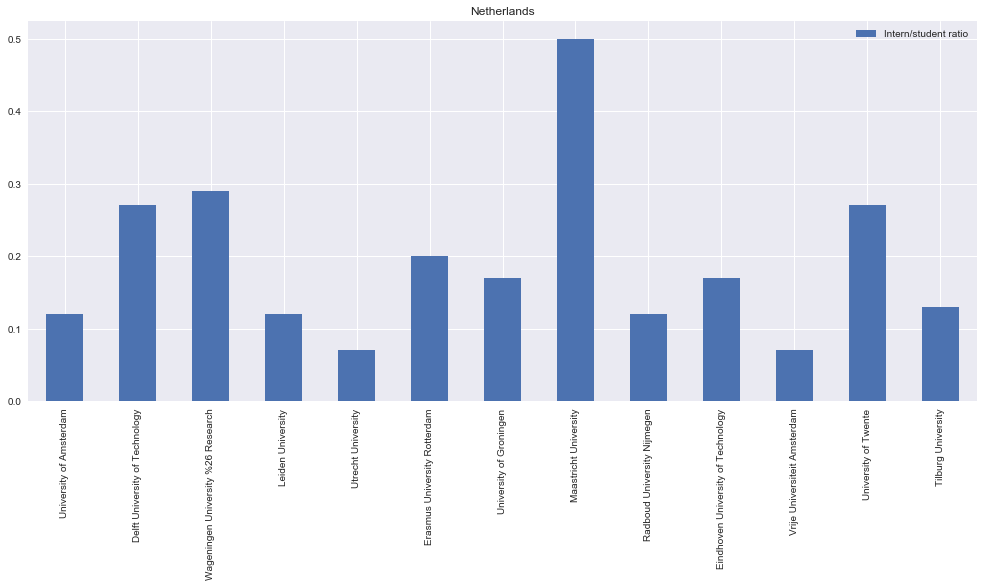

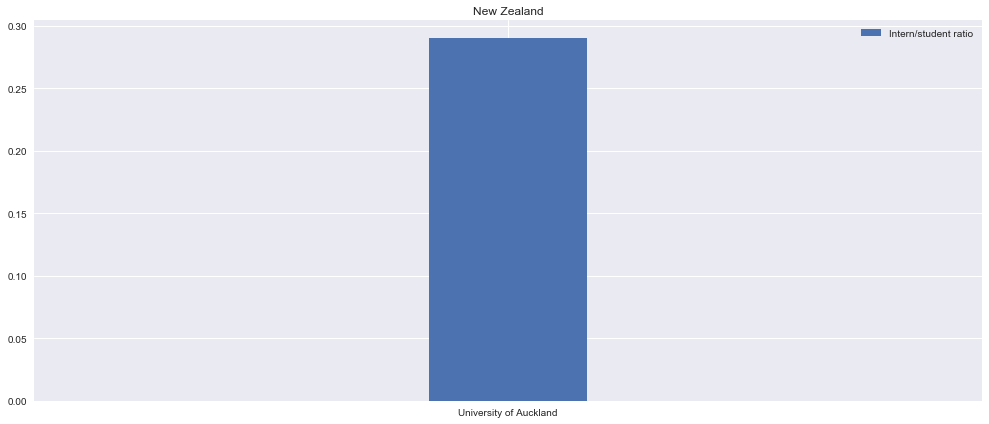

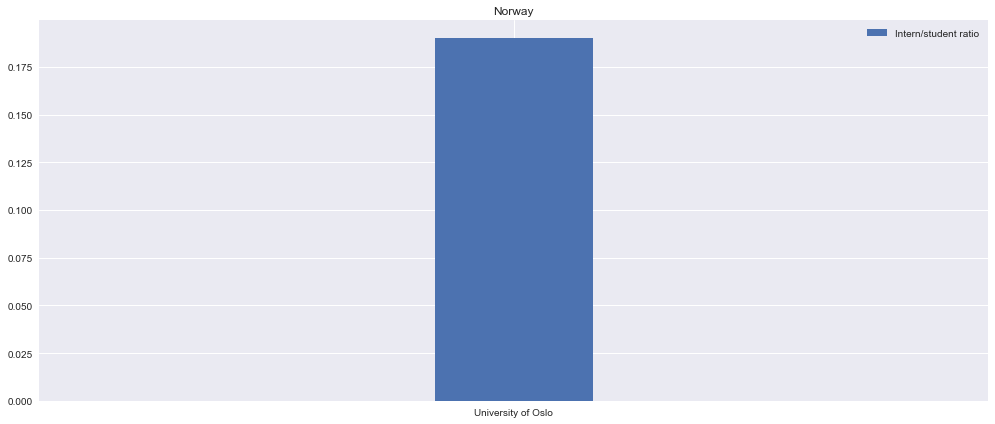

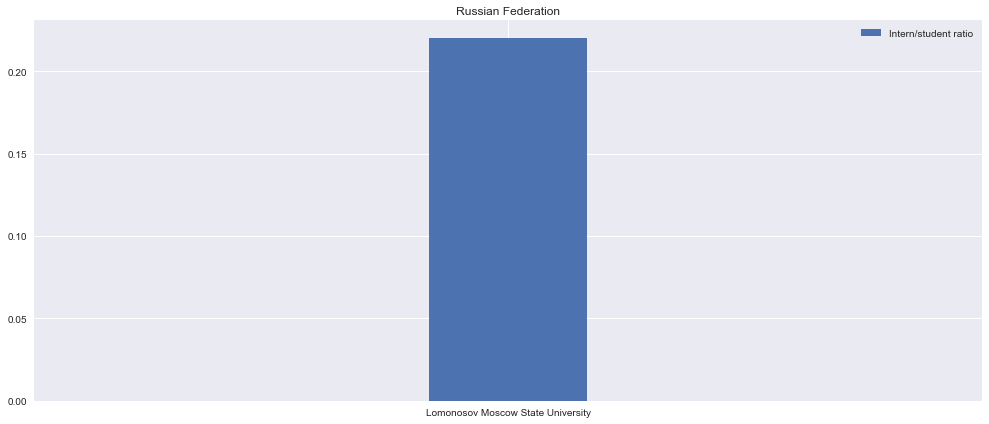

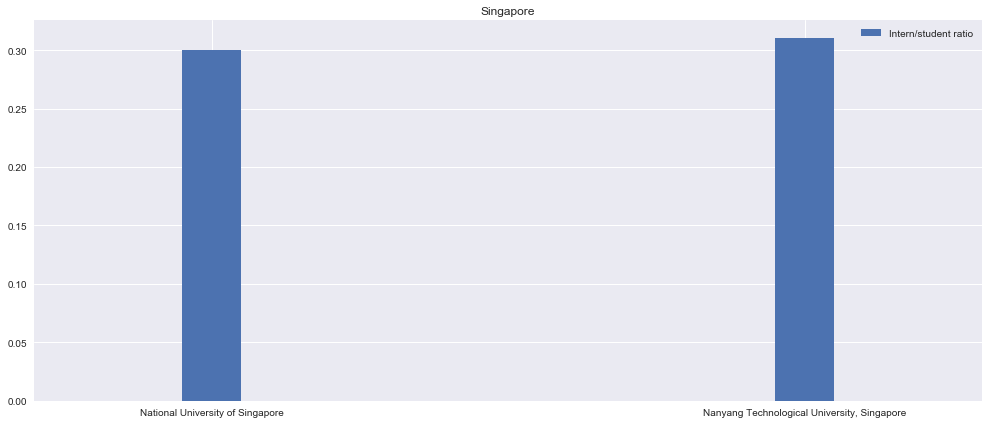

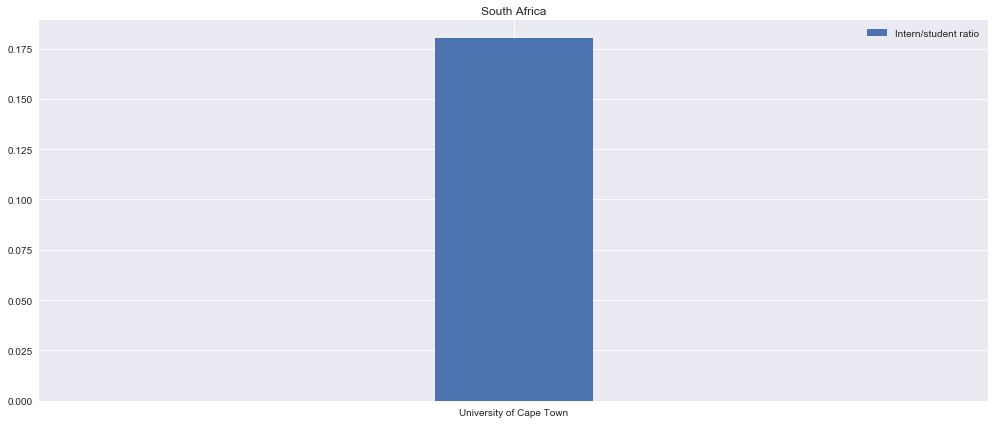

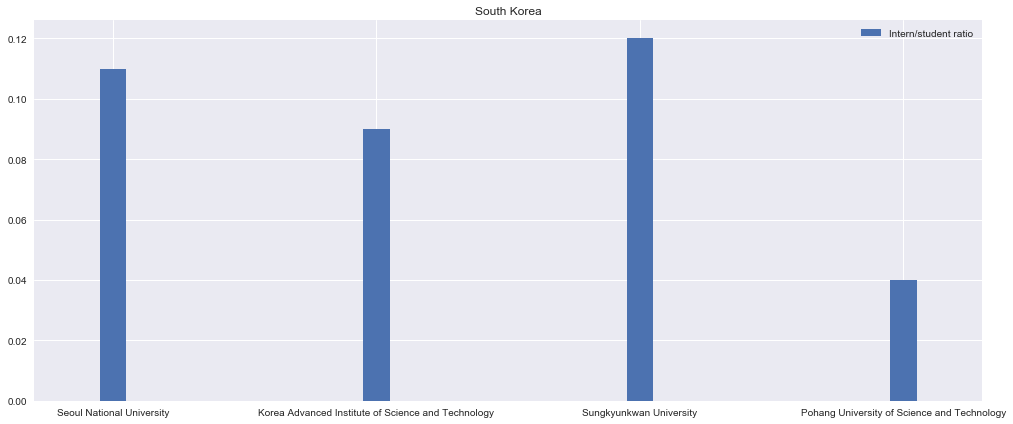

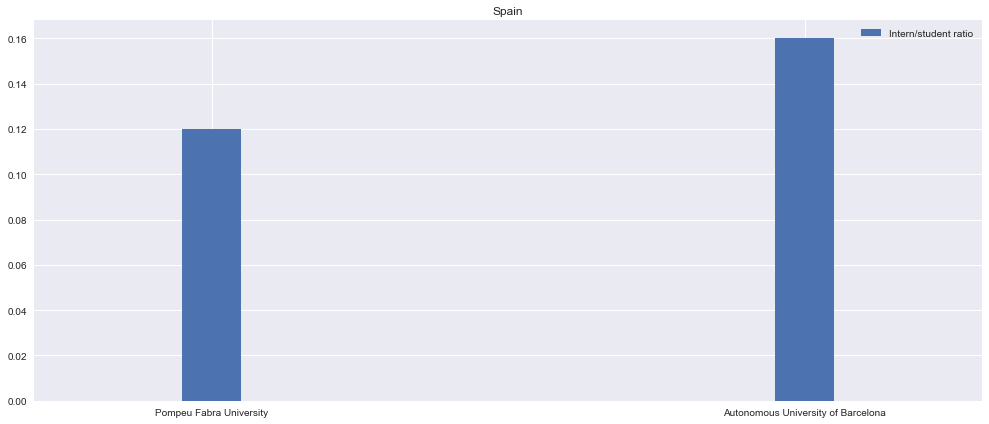

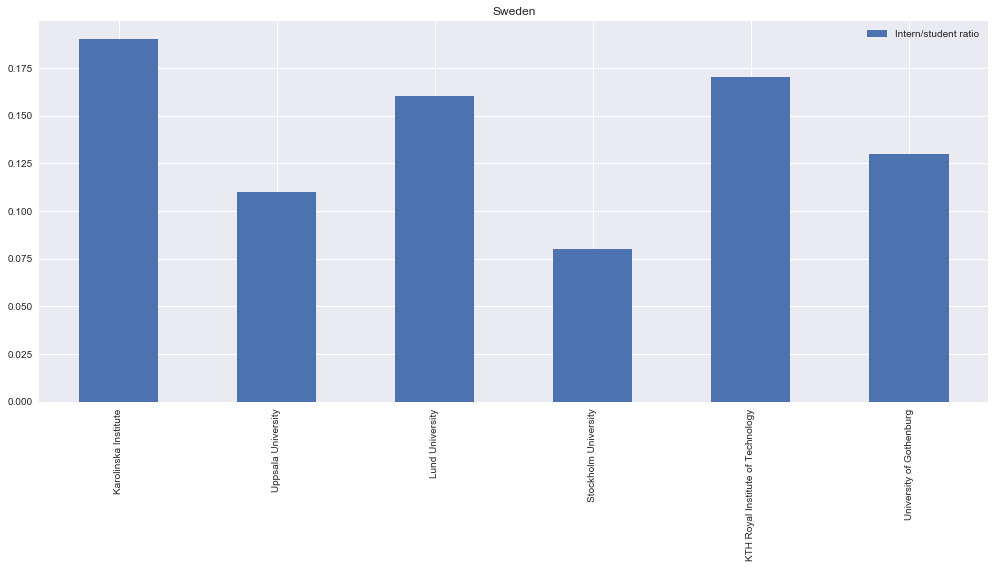

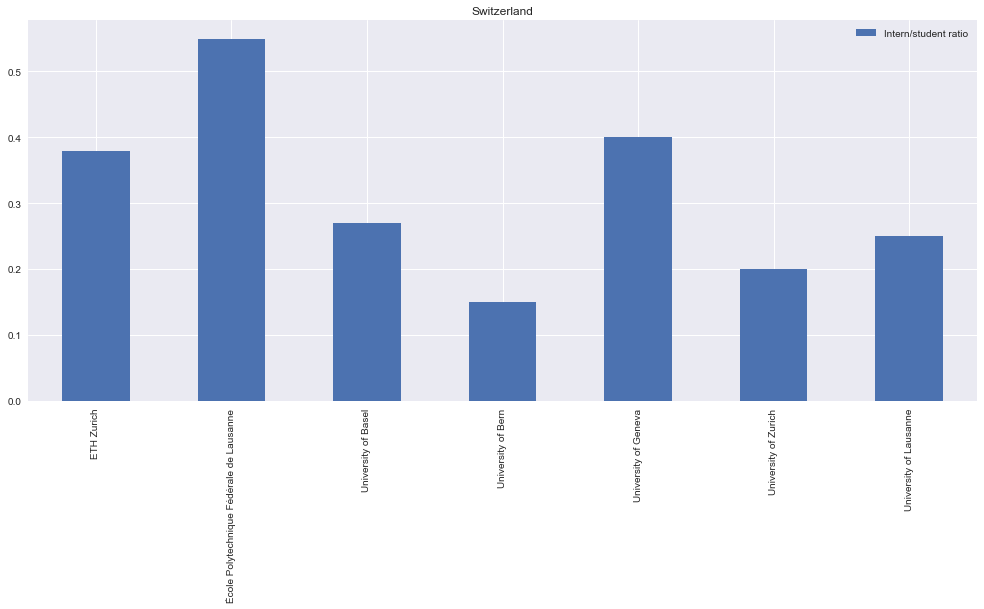

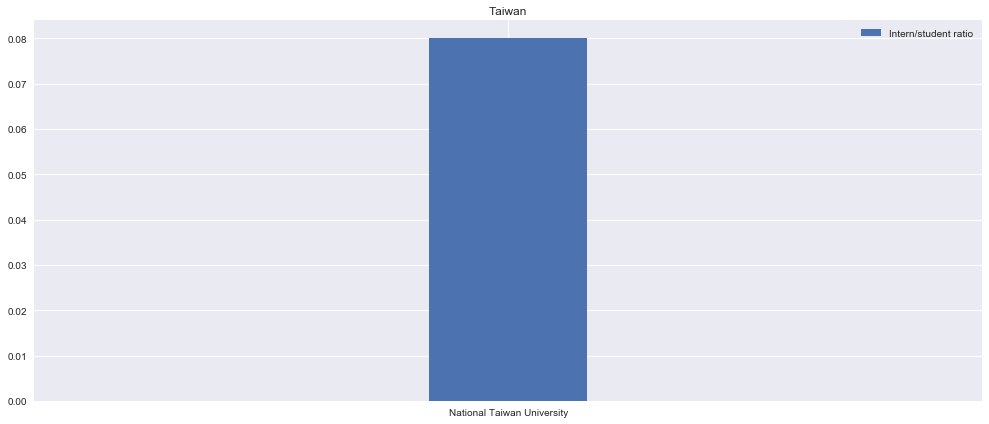

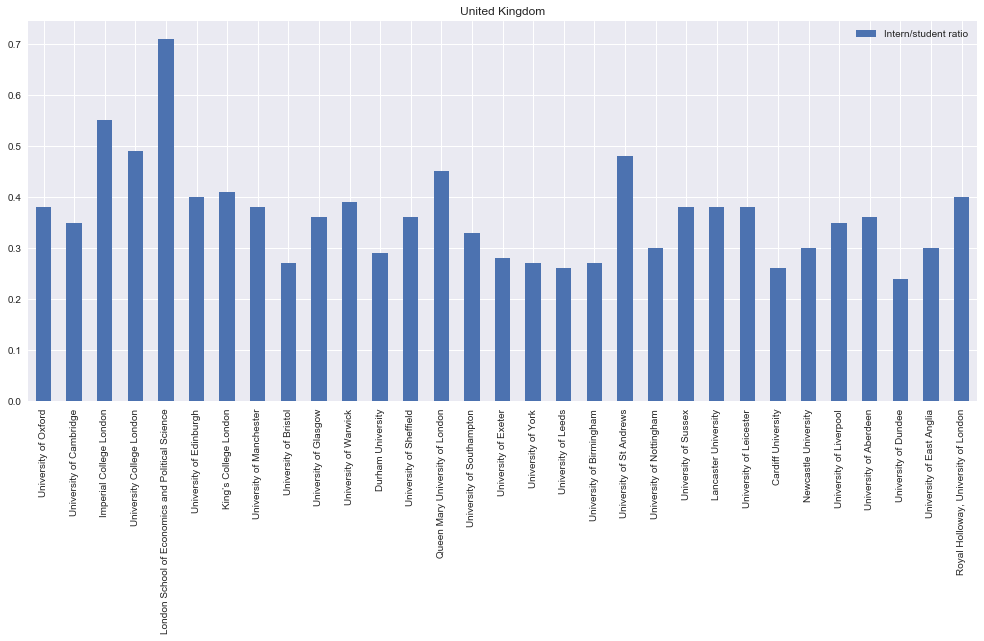

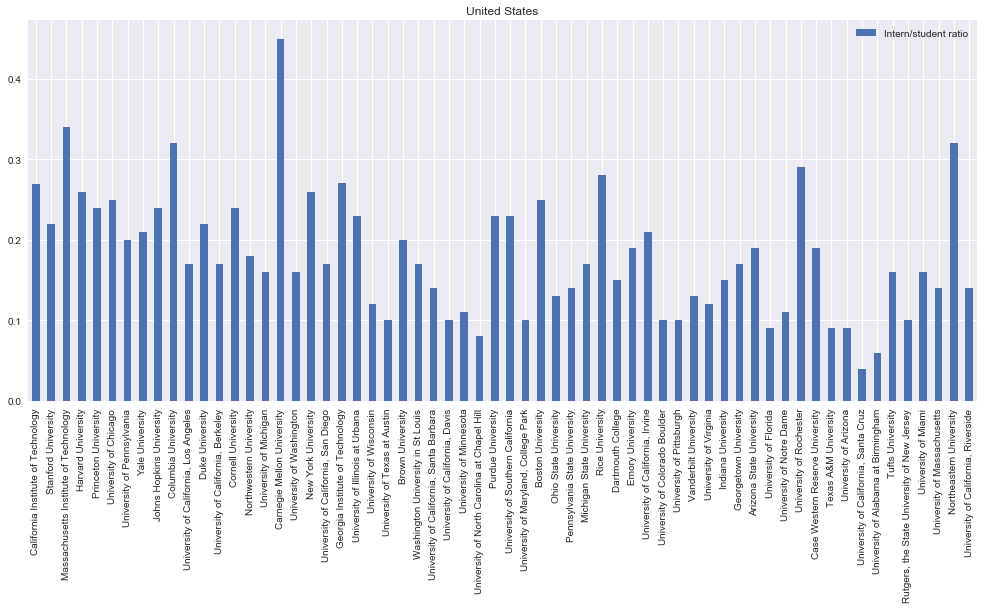

In [30]:
for i, (title, group) in enumerate(times_ranking_df.groupby('Country')):
    ax = group[['Intern/student ratio']].plot.bar(figsize=(17, 7), 
                                                                            width= 0.5 if (len(group) > 5) else 0.1)
    plt.title(title)
    plt.xticks(rotation = 90 if (len(group) > 5) else 0)
    plt.xlabel("")
    plt.show()

### Task 3 - Merge the dataframes
Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

In [31]:
qs_ranking_df['University name'] = qs_ranking_df.index
times_ranking_df['University name'] = times_ranking_df.index

In [32]:
qs_ranking_df['University name'] = qs_ranking_df['University name'].str.strip()
qs_ranking_df['Country'] = qs_ranking_df['Country'].str.strip()

times_ranking_df['University name'] = times_ranking_df['University name'].str.strip()
times_ranking_df['Country'] = times_ranking_df['Country'].str.strip()

Merging the two dataframes into one:

In [33]:
merged_ranking_df = pd.merge(qs_ranking_df, times_ranking_df, 
                             on=['University name', 'Country', 'Region'], 
                             how='outer', 
                             suffixes=('_QS', '_TM')
                            )

merged_ranking_df.set_index(['University name'], inplace=True)

merged_ranking_df

,Country,International faculty member,International student_QS,Rank_QS,Region,Total faculty member_QS,Total student_QS,Faculty/students ratio,Intern/student ratio_QS,International student_TM,Rank_TM,Total faculty member_TM,Total student_TM,Intern/student ratio_TM
University name,,,,,,,,,,,,,,
Massachusetts Institute of Technology,United States,1679.0,3717.0,1,North America,2982.0,11067.0,0.269450,0.335863,3800.0,5,1285.0,11177.0,0.339984
Stanford University,United States,2042.0,3611.0,2,North America,4285.0,15878.0,0.269870,0.227422,3486.0,=3,2113.0,15845.0,0.220006
Harvard University,United States,1311.0,5266.0,3,North America,4350.0,22429.0,0.193945,0.234785,5285.0,6,2284.0,20326.0,0.260012
California Institute of Technology,United States,350.0,647.0,4,North America,953.0,2255.0,0.422616,0.286918,596.0,=3,340.0,2209.0,0.269805
University of Cambridge,United Kingdom,2278.0,6699.0,5,Europe,5490.0,18770.0,0.292488,0.356899,6436.0,2,1687.0,18389.0,0.349992
University of Oxford,United Kingdom,2964.0,7353.0,6,Europe,6750.0,19720.0,0.342292,0.372870,7755.0,1,1822.0,20409.0,0.379979
UCL,United Kingdom,2554.0,14854.0,7,Europe,6345.0,31080.0,0.204151,0.477928,NaN,NaN,NaN,NaN,NaN
Imperial College London,United Kingdom,2071.0,8746.0,8,Europe,3930.0,16090.0,0.244251,0.543567,8721.0,8,1391.0,15857.0,0.549978
University of Chicago,United States,635.0,3379.0,9,North America,2449.0,13557.0,0.180645,0.249244,3381.0,9,2181.0,13525.0,0.249982
